# NammaMetro Ridership Data Analysis

**Last Major Update:** 2025-02-18

**Author** Mahesh Shantaram <<ms@thecontrarian.in>>

In [ ]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib.pyplot
# %pip install seaborn
# %pip install datetime
# %pip install scipy.stats

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
from matplotlib import dates as mdates
from scipy.stats import norm, t, linregress
from IPython.display import Markdown

filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)

## Table of Contents

### 1. [One Day on NammaMetro](#one-day-on-nammametro)

- Earliest Record

- Latest Record

- `Day of Week` and `Total Riders`

- Missing Days

- The Dataset at a Glance

### 2. ["The Metro is Getting Crowded!"](#the-metro-is-getting-crowded)

- Top 10 Busiest Days (Commuter Traffic)

- Top 10 Least Busy Days (Weekend Traffic)

### 3. [One Week on NammaMetro](#one-week-on-nammametro)

- Total Ridership over the Last 7 Days

- Total Ridership by Day of Week

- Average Ridership by Day of Week

- Ridership Patterns by Payment Method

### 4. [Three Traffic Bands, Two Kinds of Patrons, One Metro](#three-traffic-bands-two-kinds-of-patrons-one-metro)

- Ridership Patterns: `Commute` vs `Casual` rides by `Traffic Band`

### 4. [One Month on NammMetro](#one-month-on-nammametro)

- The Official Numbers

- Ebb and Flow of Daily Passenger Traffic

### 5. [The Long Weekend and Other Phenomena](#the-long-weekend-and-other-phenomena)

### 6. [Fare Hike Impact Analysis](#fare-hike-impact-analysis)

- Pre-Hike Commuter Payment Patterns

- Post-Hike Test of Statistical Significance

_____
## One Day on NammaMetro

#### Let's take a look at the ridership data that NammaMetro publishes daily.

![ridership_plot](nammametro_datapage.png)

The Namma Metro Ridership stats page publishes a breakdown of payment methods used daily by passengers entering the system.

Source: [https://english.bmrc.co.in/ridership/](https://english.bmrc.co.in/ridership/)

### Earliest Record

In [4]:
df.head(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Total Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
0,26-10-2024,353460,352496,853,43,68,241883,7444,512,177279,49351,95571,32357


### Latest Record

In [5]:
df.tail(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Total Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
106,27-02-2025,401617,401092,149,54,322,178083,18079,1625,165030,46014,87919,31097


### Let's create two additional useful features: `Day of Week` and `Total Riders`

In [6]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 
                                'Total Tokens', 
                                'Total NCMC', 
                                'Group Ticket', 
                                'Total QR']].sum(axis=1).astype('Int64')
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

### Missing Days

Every now and then, NammaMetro fails to report ridership numbers. 

This usually happens when the individual tasked with manually updating (!!!) the [data page](https://english.bmrc.co.in/ridership/) goes on leave. 

Let's get a better understanding of that missing data.

In [10]:
number_of_days = 180

date_range = pd.date_range(start=df['Record Date'].min(), 
                          end=df['Record Date'].max(), 
                          freq='D')
complete_df = pd.DataFrame({'Record Date': date_range})
complete_df = complete_df.merge(df, on='Record Date', how='left')
complete_df['Formatted_Date'] = complete_df['Record Date'].dt.strftime('%b %d')

print("="*40)
print(f"Last 10 Days Missing Data")
print("="*40)
missing_data = complete_df.tail(number_of_days)
missing_data['Day of Week'] = missing_data['Record Date'].dt.day_name()
missing_data = missing_data[missing_data['Total Riders'].isna()][['Record Date', 'Day of Week', 'Total Riders']]
display(missing_data.tail(10))

# For use later when creating the stacked area chart
imputed_days = missing_data['Record Date'].dt.strftime('%Y-%m-%d').tolist()

Last 10 Days Missing Data


,Record Date,Day of Week,Total Riders
65,2024-12-30,Monday,<NA>
67,2025-01-01,Wednesday,<NA>
75,2025-01-09,Thursday,<NA>
76,2025-01-10,Friday,<NA>
77,2025-01-11,Saturday,<NA>
78,2025-01-12,Sunday,<NA>
79,2025-01-13,Monday,<NA>
98,2025-02-01,Saturday,<NA>
113,2025-02-16,Sunday,<NA>
120,2025-02-23,Sunday,<NA>


### The Dataset at a Glance 

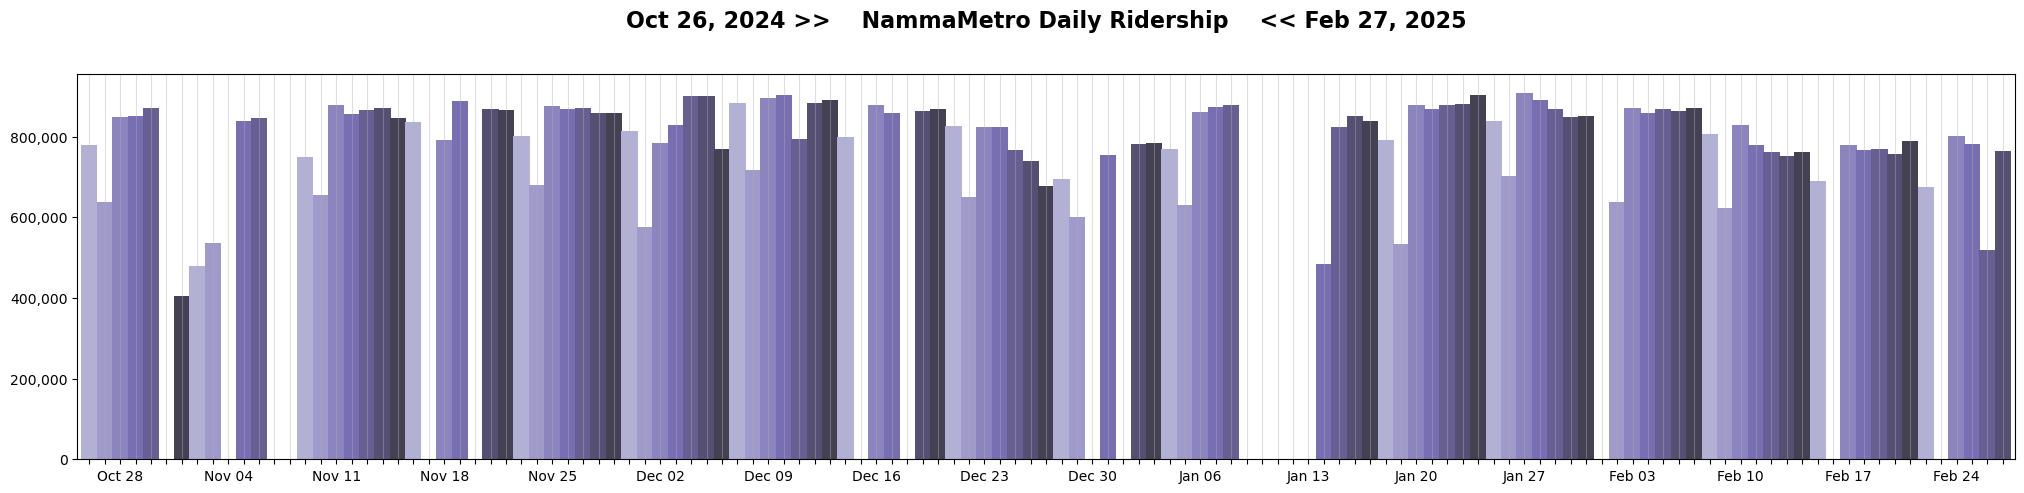

In [11]:
ax = complete_df\
    .plot(x='Formatted_Date',
          y='Total Riders',
          kind='bar',
          xlabel='',
          ylabel='',
          figsize=(25,5),
          width=1.05,
          color=sns.color_palette('Purples_d', 7),
          legend=False,
          alpha=1.0,
          rot=0)
for patch in ax.patches:
    patch.set_linewidth(0)

earliest_date = df['Record Date'].min().strftime('%b %d, %Y')
latest_date = df['Record Date'].max().strftime('%b %d, %Y')
plt.title(f"{earliest_date} >>    NammaMetro Daily Ridership    << {latest_date}", 
          fontsize=16, y=1.1, fontweight='bold')

xticks = plt.gca().get_xticklabels()
for i, (date, riders) in enumerate(zip(complete_df['Record Date'], complete_df['Total Riders'])):
    if date.weekday() == 0:
        xticks[i].set_visible(True)
        xticks[i].set_fontsize(10)
    else:
        xticks[i].set_visible(False)

plt.ylim(bottom=0)
plt.yticks(fontsize=10)
plt.grid(True, axis='x', alpha=0.4)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.show()

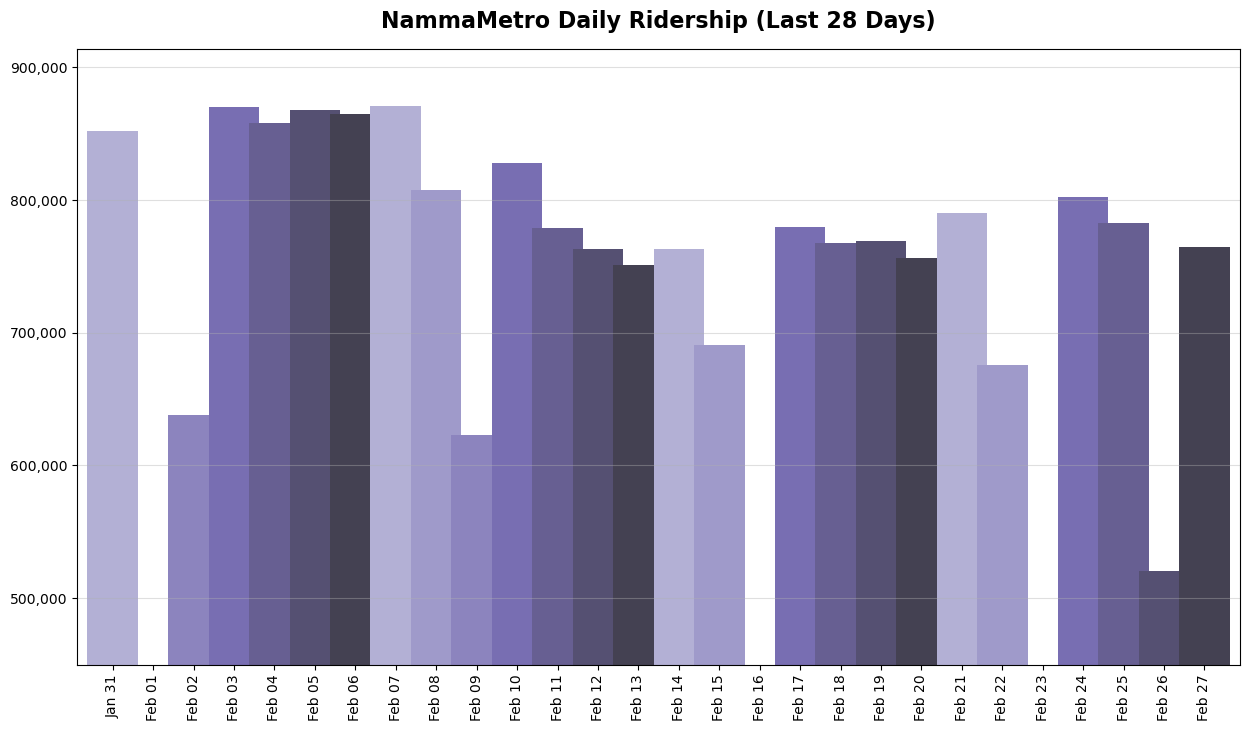

In [15]:
number_of_days = 28; base_value = 450000

truncated_df = complete_df.tail(number_of_days)
ax = truncated_df\
    .plot(x='Formatted_Date',
          y='Total Riders',
          kind='bar',
          xlabel='',
          ylabel='',
          figsize=(15,8),
          width=1.25,
          color=sns.color_palette('Purples_d', 7),
          legend=False,
          rot=90)

plt.title(f"NammaMetro Daily Ridership (Last {number_of_days} Days)",
          fontsize=16, y=1.02, fontweight='bold')

xticks = plt.gca().get_xticklabels()
plt.ylim(bottom=base_value)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', alpha=0.4)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.show()

#### Looks like a mouth with a few broken teeth!

What sort of data imputation makes sense here? 

When the dataset grows large enough over several months, it makes sense to fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4-8 available weekday Tuesdays.

_____
## "The Metro is Getting Crowded!"

![Crossed daily ridership of 700,000 in October 2023](nammametro_record1.png)

### Top 10 Busiest Days - Commuter Traffic

In [17]:
busiest_days = df[['Record Date', 'Day of Week', 'Total Riders']].sort_values('Total Riders', ascending=False)
busiest_days.reset_index(drop=True, inplace=True)
busiest_days.index = range(1, len(busiest_days) + 1)
busiest_days.head(10)

,Record Date,Day of Week,Total Riders
1,2025-01-27,Monday,909522
2,2024-12-10,Tuesday,903928
3,2025-01-24,Friday,902476
4,2024-12-04,Wednesday,901475
5,2024-12-05,Thursday,901230
6,2024-12-09,Monday,895461
7,2025-01-28,Tuesday,891111
8,2024-12-13,Friday,890143
9,2024-11-19,Tuesday,889113
10,2024-12-07,Saturday,883300


#### 👆🏼 In December 2024, NammaMetro's single-day ridership crossed 900,000 for the first time!

The ridership hit a record of 700,000 passengers in October 2023. It took just a little over a year to add 200,000 riders/day to the system.

### Least Busy Days so far - Weekend Traffic

In [18]:
busiest_days.tail(10)

,Record Date,Day of Week,Total Riders
98,2025-01-05,Sunday,629755
99,2025-02-09,Sunday,623123
100,2024-12-29,Sunday,600289
101,2024-12-01,Sunday,575702
102,2024-11-03,Sunday,536524
103,2025-01-19,Sunday,534139
104,2025-02-26,Wednesday,520284
105,2025-01-14,Tuesday,484293
106,2024-11-02,Saturday,480284
107,2024-11-01,Friday,404342


#### 👆🏼 Sundays, holidays (state and national) and major festivals are when people take a break from the metro.

_____
## One Week on NammaMetro

### Total Daily Ridership over the Last 7 days

In [19]:
df[['Record Date', 'Day of Week', 'Total Riders']].tail(7)

,Record Date,Day of Week,Total Riders
100,2025-02-20,Thursday,756200
101,2025-02-21,Friday,789952
102,2025-02-22,Saturday,675483
103,2025-02-24,Monday,802511
104,2025-02-25,Tuesday,782767
105,2025-02-26,Wednesday,520284
106,2025-02-27,Thursday,764434


### Total Daily Ridership by Day of Week

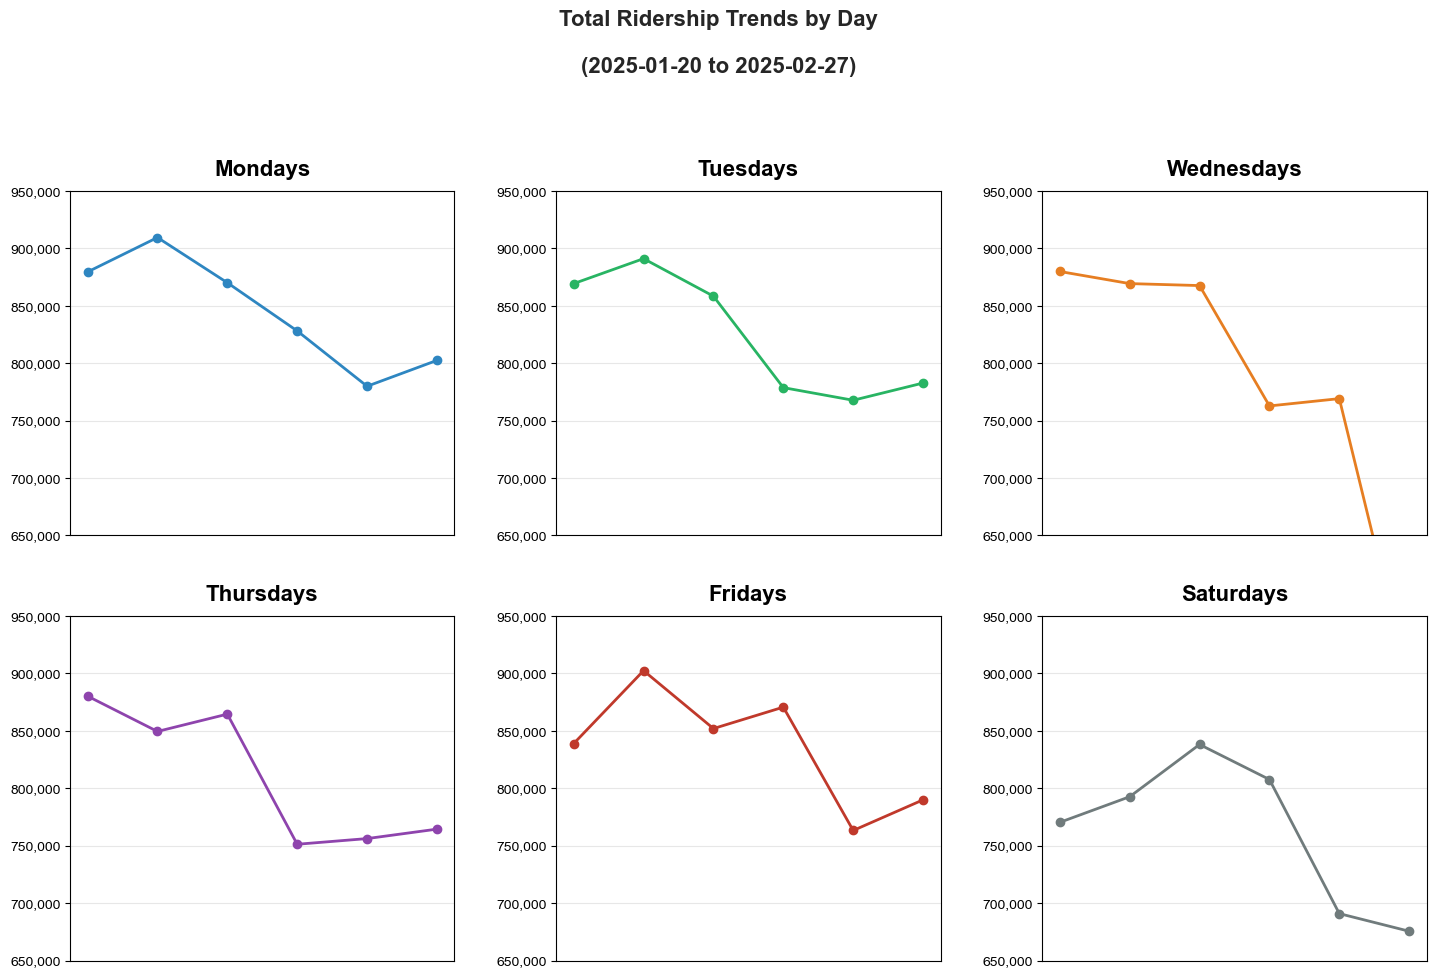

In [20]:
number_of_days = 7 * 6
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
colors = {
    'Monday':    '#2E86C1', # Blue
    'Tuesday':   '#28B463', # Green
    'Wednesday': '#E67E22', # Orange
    'Thursday':  '#8E44AD', # Purple
    'Friday':    '#C0392B', # Red
    'Saturday':  '#707B7C', # Gray
    'Sunday':    '#F1C40F'  # Yellow
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.set_style("whitegrid")
axes = axes.flatten()

def plot_day_data(ax, day, idx):
    day_data = df[df['Day of Week']==day][['Record Date', 'Total Riders']].tail(int(number_of_days/7))
    
    ax.plot(range(len(day_data)), day_data['Total Riders'], 
            marker='o', markersize=6, linewidth=2, 
            color=colors[day], label=day)
    
    ax.set_title(f'{day}s', fontsize=16, y=1.02, fontweight='bold')
    ax.set_ylabel('', fontsize=11)
    ax.grid(True, axis='both', alpha=0.3)
    ax.set_xticks([])
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.set_ylim(650000, 950000)

for idx, day in enumerate(days):
    plot_day_data(axes[idx], day, idx)

start_date = df[df['Day of Week']=='Monday'].tail(int(number_of_days/7)).reset_index().iloc[0, 1].strftime('%Y-%m-%d')
end_date = df['Record Date'].max().strftime('%Y-%m-%d')
fig.suptitle(f"Total Ridership Trends by Day\n\n({start_date} to {end_date})", 
             fontsize=16, y=1, fontweight='bold')
plt.tight_layout(pad=3.0)
plt.show()

This is a series of lineplots showing the trend in total ridership for each day of the week over the past several weeks. This makes it easy to spot patterns for specific days and answer several key questions concerning: 

- consistency (*"Are there regular patterns in how ridership fluctuates?"*)

- trends (*"Are there seasonal or cyclical patterns in day-specific ridership?"*)

- anomalies (*"Which days experienced unusual spikes or dips?"*)

- operational planning (*"Are there systematic differences between different days of the week?"*)

- recovery patterns (*"Are there lasting impacts from major events?"*)

### Average Daily Ridership by Day of Week

In [21]:

print("Number of data points available for each day of the week:")
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

Number of data points available for each day of the week:


Day of Week
Monday       15
Tuesday      18
Wednesday    15
Thursday     15
Friday       15
Saturday     16
Sunday       13
Name: count, dtype: int64

In [22]:
# Configure parameters to calculate day of week averages
number_of_days = 92
end_date = pd.to_datetime('2025-01-31')
start_date = max(end_date - pd.Timedelta(days=number_of_days-1), df['Record Date'].min())
exclude_dates = ['2025-01-14', '2025-01-15', '2025-01-16']

In [23]:

rename_map = {
    'Total Smart Cards': 'Smart Cards',
    'Total Tokens': 'Tokens',
    'Total NCMC': 'NCMC',
    'Total QR': 'QR',
    'Day of Week_x': 'Day of Week'
}
payment_columns = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

mask = (df['Record Date'] >= start_date) & (df['Record Date'] <= end_date)
if exclude_dates:
    exclude_dates = pd.to_datetime(exclude_dates)
    mask &= ~df['Record Date'].isin(exclude_dates)

weekly_average = (df[mask]
                 .rename(columns=rename_map)
                 .groupby('Day of Week')[payment_columns]
                 .mean()
                 .reindex(day_order))
weekly_average = weekly_average.apply(
    lambda x: pd.to_numeric(x.fillna(0), errors='coerce')
    .round()
    .astype('Int64'))
weekly_average['Total Riders'] = weekly_average.sum(axis=1)

print("=" * 45)
print("Average Daily Ridership by Day of Week")
print("=" * 45)
display(weekly_average)

Average Daily Ridership by Day of Week


,Smart Cards,NCMC,Tokens,QR,Group Ticket,Total Riders
Day of Week,,,,,,
Monday,441462,12493,212673,191298,561,858487
Tuesday,451571,13078,212094,177701,537,854981
Wednesday,438200,12355,209385,192182,645,852767
Thursday,450936,12935,201499,183966,571,849907
Friday,400858,11518,206976,176938,614,796904
Saturday,318807,7812,236402,210265,740,774026
Sunday,174112,4712,249686,198967,647,628124


`weekly_average` summarizes three months of metro ridership data showing the **typical number of passengers using each payment method on different days of the week**. It eliminates dates that display anomalous behaviour so that the result is more representative of an average week. **This table forms the foundation for our analysis of commuter patterns and weekend behavior ahead in the analysis.**

### Average Daily Ridership by Payment Method

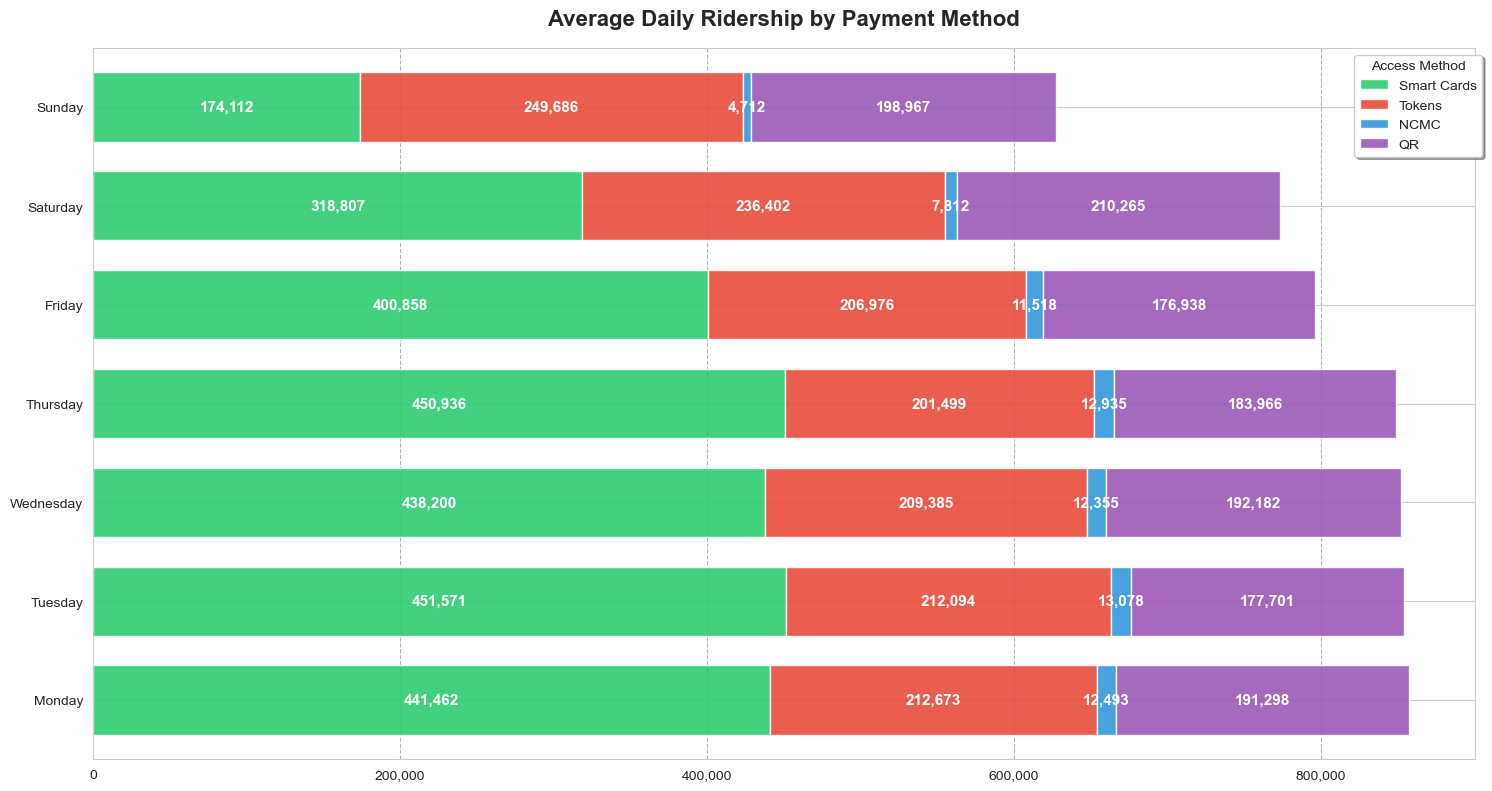

In [24]:
# Stacked histogram of Average Ridership by Day of Week

colors = {
    'Smart Cards': '#2ecc71',  # green for sustainable/reusable
    'NCMC': '#3498db',        # blue for digital/modern
    'Tokens': '#e74c3c',      # red for traditional/physical
    'QR': '#9b59b6'          # purple for digital/tech
}

ax = weekly_average.loc[:, ['Smart Cards', 'Tokens', 'NCMC', 'QR']].plot(
                             kind='barh', stacked=True, ylabel='',
                             color=[colors[col] for col in ['Smart Cards', 'Tokens', 'NCMC', 'QR']],
                             figsize=(15, 8), width=0.7, rot=0, alpha=0.9)

for c in ax.containers:
    labels = labels = [f'{int(v):,}' if v >= 4000 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=11, color='white', fontweight='bold')

plt.title('Average Daily Ridership by Payment Method', 
          fontsize=16, 
          y=1.02, 
          fontweight='bold')
plt.legend(title='Access Method', 
          bbox_to_anchor=(1.01, 1), 
          loc='best',
          frameon=True,
          fancybox=True,
          shadow=True)
plt.grid(axis='x', 
         linestyle='--', 
         alpha=0.6,
         color='gray')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

> #### 👆🏼 Surprising find — Smart Card and NCMC usage peaks during the week; Tokens and QR peaks on weekends.
>
> - From Monday to Thursday, Smart Card and NCMC usage – typically used by regular metro riders commuting to work – averages 450,000 and 12,000 respectively.
> 
> - Tokens and QR payments, typically used by non-regular metro riders, reach peak usage on Sundays. This suggests weekend and holiday demand is driven by casual users, e.g. road users who switch to public transport on the weekends.
> 
>   - **Commuters:** Officegoers who are committed to using public transport. We assume they use stored deposit value digital payment methods like Smart Cards and NCMC for efficiency. 
> 
>   - **Casual Users:** People who use public transport to run errands, get around on the weekends, etc. Typically, they use Tokens, QR, and Group Tickets to access the system.
> 
> - Looking at usage patterns by days of the week, there appears to be _three distinct traffic bands_ in Bangalore City:
> 
>   - **Weekdays:** Without doubt, Mondays through Thursdays see heavy ridership as the metro ferries people to work and back
> 
>   - **Weekend:** Total ridership on Sundays dips to 50% of the average Weekday. 
>
>   - **Weekend Lite:** Friday begins to exhibit weekend-like behaviour. But then, _Saturday is a full working day for many in this city._


_____
## Three Traffic Bands, Two Kinds of Patrons, One Metro

### Ridership Patterns: `Commute` vs `Casual` rides by `Traffic Band`

Given what we have learned so far, let us introduce new data features into our dataframe:

- `Commute`: Sum of Smart Cards and NCMC users, representing regular travelers who prefer reusable payment methods

- `Casual`: Sum of Tokens, QR tickets, and Group tickets, representing occasional travelers who opt for single-journey payment methods

- `Traffic Band`: Weekday (Mon-Thu), Weekend Lite (Fri-Sat) or Weekend (Sun)

In [25]:
# Create df2 with new features for further analysis
df2 = df.copy()

# Create additional features: Day of Week, Traffic Band
df2['Day of Week'] = df2['Record Date'].dt.strftime('%A')
df2['Traffic Band'] = 'Weekday'
df2.loc[(df2['Record Date'].dt.dayofweek >= 4), 'Traffic Band'] = 'Weekend Lite'
df2.loc[(df2['Record Date'].dt.dayofweek == 6), 'Traffic Band'] = 'Weekend'

# Create additional features Commute, Casual and Total
df2['Commute'] = df2['Total Smart Cards'] + df2['Total NCMC']
df2['Casual'] = df2['Total Tokens'] + df2['Total QR'] + df2['Group Ticket']
df2['Total'] = df2['Commute'] + df2['Casual']

# Select features for new dataframe
df2.rename(columns={
    # 'Record Date': 'Date',
    # 'Day of Week':,
    'Total Smart Cards': 'Smart Cards',
    'Total NCMC': 'NCMC',
    # 'Commute':,
    'Total Tokens': 'Tokens',
    'Total QR': 'QR',
    # 'Group Ticket':,
    # 'Casual':,
    # 'Total':,
}, inplace=True)

df2 = df2[['Record Date', 'Day of Week', 'Traffic Band', 'Smart Cards', 'NCMC', 'Commute', 'Tokens', 'QR', 'Group Ticket', 'Casual', 'Total']]
display(df2)

,Record Date,Day of Week,Traffic Band,Smart Cards,NCMC,Commute,Tokens,QR,Group Ticket,Casual,Total
0,2024-10-26,Saturday,Weekend Lite,353460,7444,360904,241883,177279,512,419674,780578
1,2024-10-27,Sunday,Weekend,176278,4278,180556,250124,205910,458,456492,637048
2,2024-10-28,Monday,Weekday,452257,11076,463333,208014,177629,160,385803,849136
3,2024-10-29,Tuesday,Weekday,452299,10948,463247,205421,182210,407,388038,851285
4,2024-10-30,Wednesday,Weekday,425759,9975,435734,233366,201583,198,435147,870881
...,...,...,...,...,...,...,...,...,...,...,...
102,2025-02-22,Saturday,Weekend Lite,246807,11027,257834,224326,192617,706,417649,675483
103,2025-02-24,Monday,Weekday,419033,18984,438017,190998,173063,433,364494,802511
104,2025-02-25,Tuesday,Weekday,418523,19454,437977,177694,166474,622,344790,782767
105,2025-02-26,Wednesday,Weekday,216490,10486,226976,160400,132520,388,293308,520284


In [26]:
# Weekly Ridership Pattern Table
traffic_bands = {
    'Monday': ('Weekday', '#e6f0ff'),      # Slightly deeper blue-white
    'Tuesday': ('Weekday', '#e6f0ff'),
    'Wednesday': ('Weekday', '#e6f0ff'),
    'Thursday': ('Weekday', '#e6f0ff'),
    'Friday': ('Weekend Lite', '#ffe6e6'),  # Slightly deeper pink-white
    'Saturday': ('Weekend Lite', '#ffe6e6'),
    'Sunday': ('Weekend', '#f0e6ff')        # Slightly deeper purple-white
}
table_lines = []
table_lines.append("<center><table style='color: black'>")
headers = ['Day of Week', 'Traffic Band', 'Commute', 'Casual', 'Total']
table_lines.append("<tr style='background-color: black; color: white'><th>" + "</th><th>".join(headers) + "</th></tr>")
weekly_average['Commute'] = weekly_average['Smart Cards'] + weekly_average['NCMC']
weekly_average['Casual'] = weekly_average['Tokens'] + weekly_average['QR'] + weekly_average['Group Ticket']
weekly_average['Total'] = weekly_average['Commute'] + weekly_average['Casual']

for day in list(traffic_bands):
    band, color = traffic_bands[day]
    table_lines.append(f'<tr style="background-color: {color}">')
    row_data = [
        day,
        band,
        f"{int(weekly_average.loc[day, 'Commute']):,}",
        f"{int(weekly_average.loc[day, 'Casual']):,}",
        f"{int(weekly_average.loc[day, 'Total']):,}"
    ]
    table_lines.append("    <td>" + "</td>    <td>".join(row_data) + "</td>")
    table_lines.append("</tr>")

table_lines.append("</table></center>")
display(Markdown(" ".join(table_lines)))

<center><table style='color: black'> <tr style='background-color: black; color: white'><th>Day of Week</th><th>Traffic Band</th><th>Commute</th><th>Casual</th><th>Total</th></tr> <tr style="background-color: #e6f0ff">     <td>Monday</td>    <td>Weekday</td>    <td>453,955</td>    <td>404,532</td>    <td>858,487</td> </tr> <tr style="background-color: #e6f0ff">     <td>Tuesday</td>    <td>Weekday</td>    <td>464,649</td>    <td>390,332</td>    <td>854,981</td> </tr> <tr style="background-color: #e6f0ff">     <td>Wednesday</td>    <td>Weekday</td>    <td>450,555</td>    <td>402,212</td>    <td>852,767</td> </tr> <tr style="background-color: #e6f0ff">     <td>Thursday</td>    <td>Weekday</td>    <td>463,871</td>    <td>386,036</td>    <td>849,907</td> </tr> <tr style="background-color: #ffe6e6">     <td>Friday</td>    <td>Weekend Lite</td>    <td>412,376</td>    <td>384,528</td>    <td>796,904</td> </tr> <tr style="background-color: #ffe6e6">     <td>Saturday</td>    <td>Weekend Lite</td>    <td>326,619</td>    <td>447,407</td>    <td>774,026</td> </tr> <tr style="background-color: #f0e6ff">     <td>Sunday</td>    <td>Weekend</td>    <td>178,824</td>    <td>449,300</td>    <td>628,124</td> </tr> </table></center>

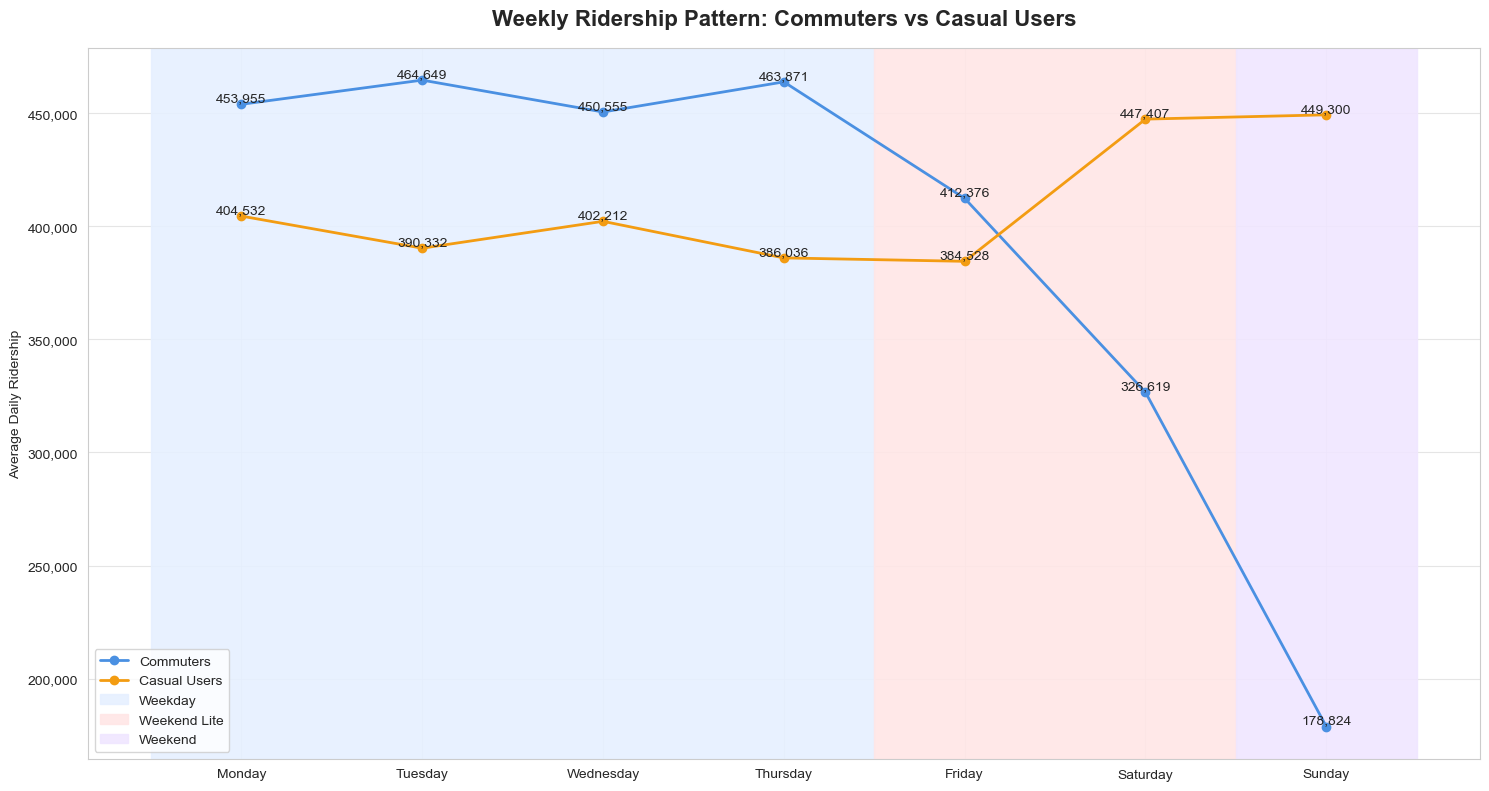

In [27]:
# Weekly Ridership Pattern Line Plot
plt.figure(figsize=(15, 8))
plt.plot(weekly_average.index, weekly_average['Commute'], 
         marker='o', linewidth=2, label='Commuters', 
         color='#4a90e2')
plt.plot(weekly_average.index, weekly_average['Casual'], 
         marker='o', linewidth=2, label='Casual Users', 
         color='#f39c12')

plt.axvspan(-0.5, 3.5, color='#e6f0ff', alpha=0.9, label='Weekday')
plt.axvspan(3.5, 5.5, color='#ffe6e6', alpha=0.9, label='Weekend Lite')
plt.axvspan(5.5, 6.5, color='#f0e6ff', alpha=0.9, label='Weekend')

plt.title('Weekly Ridership Pattern: Commuters vs Casual Users', 
         fontsize=16, y=1.02, fontweight='bold')
plt.xlabel('')
plt.ylabel('Average Daily Ridership')
plt.grid(True, alpha=0.5)
plt.legend(loc="lower left")

for category, col in [('Commuters', 'Commute'), ('Casual Users', 'Casual')]:
    for i, value in enumerate(weekly_average[col]):
        plt.text(i, value, f'{int(value):,}', 
                ha='center', va='bottom', fontsize=10)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

> #### 💡 **Two Kinds of Patrons: Commuters and Casual Users**
> 
> Ridership starts to dip on Fridays (perhaps due to liberal work-from-office policies in the IT industry or commuters preferring to use their personal vehicles.) For another segment of workers, Saturdays are as much a working day as the rest of the week.
>
> On Sundays, Smart Cards+NCMC usage sees a ~60% drop from average Weekday levels. Tokens+QR increases by ~15%. 
> 
> #### This behaviour confirms the presence of two distinct types of users: Commuters and Casual Users. NammaMetro thus exhibits a dual role as a commuter necessity on weekdays** and a convenient transport option on weekends and holidays.

> #### 💡 **Weekdays – _Just Another Manic Monday to Thursday_**
> 
> - This visualization validates our hypothesis about Bangalore's distinct traffic bands and rider categories. During weekdays, defined as Monday to Thursday, commuter ridership dominates, showing a consistent pattern that reflects the city's work rhythm. These commuters rely on Smart Cards and NCMC to quickly move in and out of the NammaMetro system.
> 
> #### 💡 **Weekend *Lite* – _Should I Stay or Should I Go?_**
> 
> - A remarkable crossover occurs in this band. Friday marks a clear shift where casual ridership begins to rise while commuter numbers decline. This pattern becomes even more pronounced on Saturday, where casual users nearly match commuter levels, suggesting a transformation in how the metro serves the city's needs – from a commuting utility to a general transportation option.
> 
> #### 💡 **Weekend – _A Day of Rest (For Coders But Not QR Coders)_**
> 
> - The starkest contrast appears on Sundays, where the two rider categories tell very different stories. Commuter numbers plummet to their lowest point while casual ridership reaches peak levels. This dramatic reversal reveals how the metro adapts to serve leisure travelers and weekend activities even as regular commuters largely stay home.
> 
> #### This pattern not only confirms our three-band traffic model but also reveals how different segments of Bangalore's population use the metro system throughout the week, shifting from a commuter-dominated service to one that primarily serves casual travelers during weekends.

______
## One Month on NammaMetro

### The Official Numbers

Remember that NammaMetro fails to report ridership numbers on some days, so the monthly ridership totals calculated from the data is going to be only an approximate. However, we can still identify trends and patterns by analysing data movement on a granular level.

Here are the official monthly ridership stats as reported by BMRCL:

<small>

**Month**      | **Ridership**
---------------|---------------
2024 July      | 23,633,166
2024 August    | Unavailable
2024 September | 23,072,685
2024 October   | Unavailable
2024 November  | 23,613,895
2024 December  | 24,982,906
2025 January   | 24,914,736

</small>

In [28]:
def trimmed_df(df, number_of_days=None, end_date=None, exclude_dates=None, weekly_average=None):
    """
    Return a trimmed DataFrame based on date parameters.
    If weekly_average is provided, uses it to impute missing values.
    Always includes is_imputed column (False for original data).
    """
    # Create working copy
    result = df.copy()
    
    # Handle date parameters
    end_date = pd.to_datetime(end_date) if end_date else result['Record Date'].max()
    if number_of_days:
        start_date = end_date - pd.Timedelta(days=number_of_days-1)
        result = result[result['Record Date'] >= start_date]
    result = result[result['Record Date'] <= end_date]
    
    # Handle exclusions
    if exclude_dates:
        exclude_dates = pd.to_datetime(exclude_dates)
        for date in exclude_dates:
            result = result[result['Record Date'] != date]    
    
    if weekly_average is not None:
        # Create complete date range
        date_range = pd.date_range(start=result['Record Date'].min(), 
                                 end=result['Record Date'].max(), 
                                 freq='D')
        date_range = date_range[~date_range.isin(exclude_dates)] if exclude_dates else date_range
        
        # Create base DataFrame with all dates
        complete = pd.DataFrame(index=date_range)
        complete.index.name = 'Record Date'
        complete = complete.reset_index()
        complete['Day of Week'] = complete['Record Date'].dt.strftime('%A')
        
        # Mark original dates before merge for accurate imputation flag
        result['_original'] = True
        
        # Merge with actual data
        result = complete.merge(result, how='left', on=['Record Date', 'Day of Week'])
        
        # Set imputation flag before filling values
        result['is_imputed'] = result['_original'].isna()
        result = result.drop('_original', axis=1)
        
        # Impute missing values
        numeric_cols = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket', 
                       'Commute', 'Casual', 'Total']
        for col in numeric_cols:
            if col in weekly_average.columns:
                mask = result[col].isna()
                result.loc[mask, col] = result.loc[mask, 'Day of Week'].map(weekly_average[col])
                result[col] = result[col].round().astype('Int64')
        
        # Ensure Traffic Band is set
        result['Traffic Band'] = 'Weekday'
        result.loc[result['Record Date'].dt.dayofweek >= 4, 'Traffic Band'] = 'Weekend Lite'
        result.loc[result['Record Date'].dt.dayofweek == 6, 'Traffic Band'] = 'Weekend'
    else:
        # If no imputation, all rows are original data
        result['is_imputed'] = False
    
    return result.sort_values('Record Date').reset_index(drop=True)

In [29]:

print("="*35)
print("Total Rides Served per Month ⁺")
print("="*35)

month_df = trimmed_df(df2, weekly_average=weekly_average)
month_df = month_df[month_df['Record Date'] >= '2024-11-01'].groupby(
           month_df['Record Date'].dt.to_period('M'))['Total'].sum()
month_df = round(month_df / 1000000, 3)
month_df = pd.DataFrame(month_df).reset_index()
month_df.rename(columns={'Record Date':'Year-Month', 'Total':'Monthly Total (millions)'}, inplace=True)
month_df["Daily Average (thousands)"] = round(pd.to_numeric(month_df['Monthly Total (millions)'] / month_df['Year-Month'].dt.daysinmonth * 1000), 3)
display(month_df)

print(f"⁺ Estimate based on available data as on {df2['Record Date'].max().strftime('%Y-%m-%d')}\n  plus extrapolation based on day averages.")

Total Rides Served per Month ⁺


,Year-Month,Monthly Total (millions),Daily Average (thousands)
0,2024-11,23.704,790.133
1,2024-12,24.703,796.871
2,2025-01,24.991,806.161
3,2025-02,20.414,729.071


⁺ Estimate based on available data as on 2025-02-27
  plus extrapolation based on day averages.


### Ebb and Flow of Daily Passenger Traffic

#### Visually examine the flow of total passenger traffic during the last several days, weeks and months. 

In [30]:
def plot_ridership_trend(df, traffic_band='all', user_type='all', base_value=0, ax=None):
    """
    Plot ridership trend with optional filtering by traffic band and user type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame in df2 format with Record Date, Traffic Band, Commute, Casual columns
    traffic_band : str, optional
        Filter for traffic type: 'all', 'Weekday', 'Weekend Lite', 'Weekend' (default: 'all')
    user_type : str, optional
        Filter for user type: 'all', 'Commute', 'Casual' (default: 'all')
    base_value : int, optional
        Base value for the y-axis (default: 0)
    ax : matplotlib.axes._axes.Axes, optional
        Axes object to plot on. If None, a new figure and axes will be created.
    """

    data = df.copy()
    
    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    else:
        fig = ax.figure  # Get the figure from the provided axes

    # Apply necessary filters
    if traffic_band != 'all':
        data = data[data['Traffic Band'] == traffic_band]
    if user_type != 'all':
        data['Total'] = data[user_type]
    if len(data) == 0:
        print(f"No data available after applying filters")
        return None, None
    data = data.sort_values('Record Date').reset_index(drop=True)
    
    # Fill between for all data
    if user_type == 'Commute':
        line_color = '#f39c12'  # orange for Commuters
    elif user_type == 'Casual':
        line_color = '#4a90e2'  # blue for Casual Users
    else:
        line_color = '#8B2183'  # purple for Total/default
    ax.fill_between(data['Record Date'], 
                     data['Total'],
                     y2=base_value,
                     alpha=0.2,
                     color=line_color,
                     linewidth=2 + int(line_color != '#8B2183'))

    # Find gaps in dates
    date_series = pd.Series(data['Record Date'])
    date_gaps = date_series.diff() > pd.Timedelta(days=1)
    gap_indices = date_gaps[date_gaps].index.tolist()
    
    if gap_indices:
        # Plot first segment
        ax.plot(data.loc[:gap_indices[0]-1, 'Record Date'],
                data.loc[:gap_indices[0]-1, 'Total'],
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                label='Daily Ridership (Actual Data)')
        
        # Add dummy plot for legend
        ax.plot([], [], 
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                linestyle='--',
                label='Daily Ridership (Gaps in Data)')
        
        # Plot segments and gaps
        for i in range(len(gap_indices)):
            start_idx = gap_indices[i]
            end_idx = gap_indices[i+1]-1 if i < len(gap_indices)-1 else len(data)-1
            
            # Plot segment
            ax.plot(data.loc[start_idx:end_idx, 'Record Date'],
                    data.loc[start_idx:end_idx, 'Total'],
                    color=line_color,
                    linewidth=2 + int(line_color != '#8B2183'))
            
            # Plot gap
            if i < len(gap_indices):
                ax.plot([data.loc[start_idx-1, 'Record Date'], 
                         data.loc[start_idx, 'Record Date']],
                        [data.loc[start_idx-1, 'Total'], 
                         data.loc[start_idx, 'Total']],
                        color=line_color,
                        linewidth=2 + int(line_color != '#8B2183'),
                        linestyle='--')
    else:
        # No gaps, plot as single line
        ax.plot(data['Record Date'], 
                data['Total'],
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                label='Daily Ridership')

    # Add regression line for non-zero values
    valid_data = data[data['Total'] > 0]
    if len(valid_data) > 1:  # Need at least 2 points for regression
        date_nums = mdates.date2num(valid_data['Record Date'])
        slope, intercept, r_value, p_value, std_err = linregress(date_nums, valid_data['Total'].values)
        line = slope * date_nums + intercept
        avg_riders = valid_data['Total'].mean()
        ax.axhline(y=avg_riders, color='#27AE60', linestyle='--', alpha=0.8,
                    label=f'Average ({int(avg_riders):,} riders)')
        ax.plot(valid_data['Record Date'], line, '--', 
                color='#D4268E',
                alpha=0.8, 
                label=f'Trend (R² = {r_value**2:.3f})')
        
        # Add confidence intervals
        conf = 0.95
        n = len(date_nums)
        mean_x = np.mean(date_nums)
        se = std_err * np.sqrt(1/n + (date_nums - mean_x)**2 / np.sum((date_nums - mean_x)**2))
        ci = t.ppf((1 + conf)/2, n - 2) * se
        ax.fill_between(valid_data['Record Date'], 
                         line - ci, line + ci, 
                         color='r', alpha=0.1)

    # Create title
    title_parts = ["Total Daily Ridership"]
    start_date = data['Record Date'].min()
    end_date = data['Record Date'].max()
    if traffic_band != 'all' or user_type != 'all':
        title_parts.append("–")
    if traffic_band != 'all':
        title_parts.append(f"{traffic_band}")
    if user_type != 'all':
        title_parts.append(f"{user_type}")
    title_parts.append(f"\n\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})")
    title = " ".join(title_parts)

    ax.set_title(title, fontsize=16, y=1.02, fontweight='bold')
    ax.set_ylabel('Daily Ridership', fontsize=12)
    ax.grid(True, axis='both', alpha=0.3)
    ax.set_ylim(bottom=base_value, top=1000000 if user_type=='all' else 800000)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Format x-axis dates
    ax.set_xticks(data['Record Date'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)
    plt.tight_layout()

    if ax is None:
        plt.show()
        return fig, ax  # Return fig and ax when creating a new plot
    else:
        return None, None  # Return None, None when using an existing ax

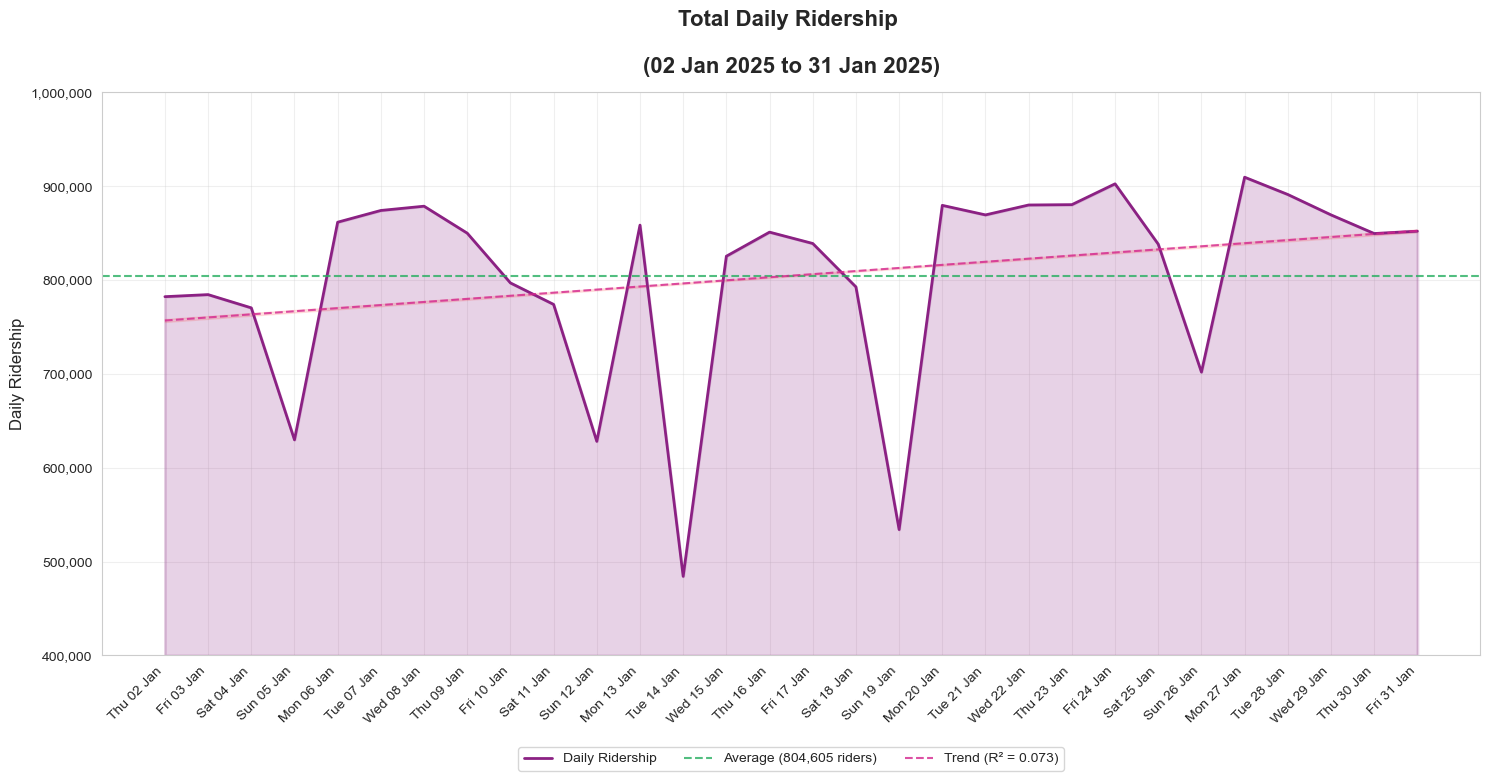

In [31]:
plot_this_df = trimmed_df(df2, number_of_days=31, end_date='2025-01-31', weekly_average=weekly_average)
ax = plot_ridership_trend(plot_this_df, base_value=400000)

#### 📘 Notes
 
1. **Weekly Pattern:** The plot reveals strong weekly cycles. Each weekend dip is followed by a sharp recovery, demonstrating the metro's vital role in weekday commuting.

2. **Trend Significance:** While the trend line suggests a slight increase in ridership, this pattern is too weak for meaningful forecasting.

3. **Further Analysis:** The high variability in aggregate data suggests we should segment our analysis. This may reveal patterns that are currently masked by day-to-day fluctuations.

##

#### 📘 R² Interpretation Scale

R² value (ranging from 0.0 to 1.0) is a measure of how well the regression line explains variability in ridership data.

<small>

| R² Range | Interpretation | Use Case |
|----------|---------------|-----------|
| > 0.75 | Very Strong | Highly reliable for forecasting |
| 0.50 - 0.75 | Strong | Good for general predictions |
| 0.25 - 0.50 | Moderate | Use with caution |
| 0.10 - 0.25 | Weak | Not suitable for predictions |
| ≤ 0.10 | Very Weak | Indicates random behavior |

</small>

_____
## The Long Weekend and Other Phenomena

### Sankranti and Something Else

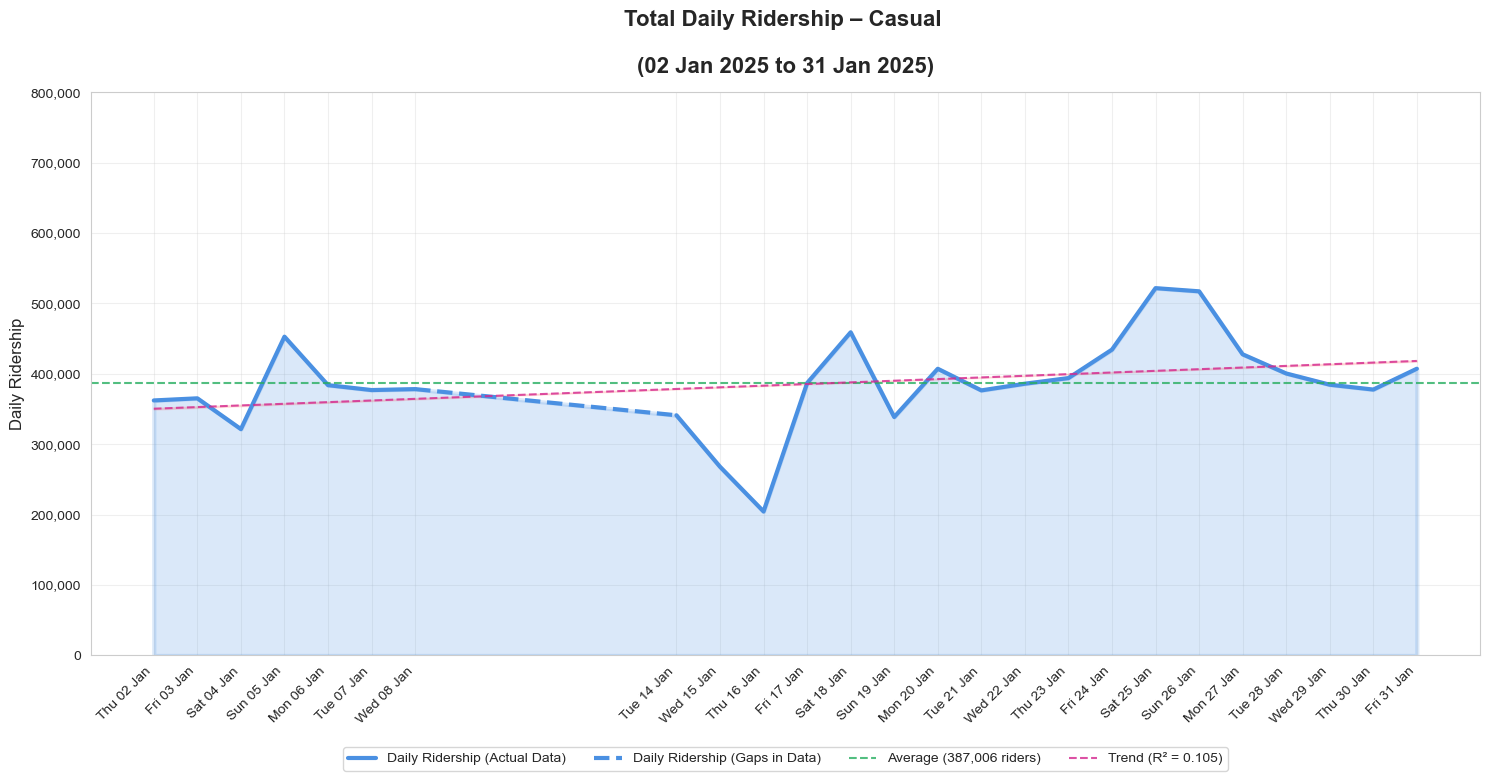

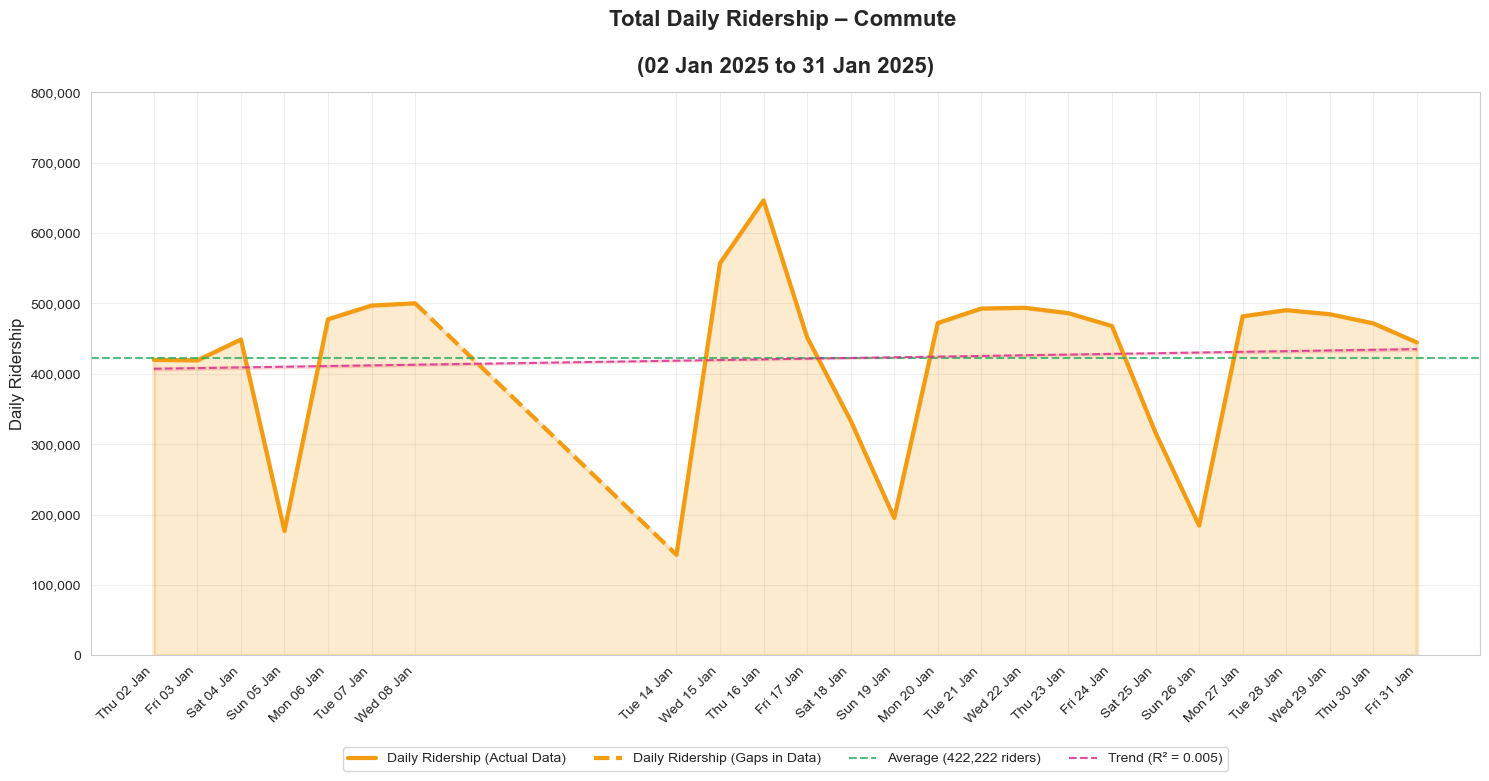

In [34]:
plot_this_df = trimmed_df(df2, number_of_days=31, end_date='2025-01-31')
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Casual', base_value=00000)
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Commute', base_value=00000)

### Ridership Stacked by Users and Payments

In [37]:
def plot_stacked_ridership(df, stack_by='user', traffic_band='all', base_value=0, ax=None):
    """
    Plot stacked histogram of ridership data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame in df2 format with Record Date, Traffic Band, Commute, Casual columns
    stack_by : str, optional
        What to stack by: 'user' (Commute/Casual) or 'payment' (Smart Cards/Tokens/etc)
        (default: 'user')
    traffic_band : str, optional
        Filter for traffic type: 'all', 'Weekday', 'Weekend Lite', 'Weekend' (default: 'all')
    base_value : int, optional
        Base value for the y-axis (default: 0)
    ax : matplotlib.axes._axes.Axes, optional
        Axes object to plot on. If None, a new figure and axes will be created.
    """
    data = df.copy()

    if traffic_band != 'all':
        data = data[data['Traffic Band'] == traffic_band]    
    if len(data) == 0:
        print(f"No data available after applying filters")
        return None, None
    data = data.sort_values('Record Date').reset_index(drop=True)
    start_date = data['Record Date'].min()
    end_date = data['Record Date'].max()
    number_of_days = len(data)

    if stack_by == 'user':
        value_vars = ['Casual', 'Commute']
        palette = ['#8fc0ee', '#ffd690']
        title_prefix = 'User Type'
    elif stack_by == 'payment':
        value_vars = ['Group Ticket', 'QR', 'Tokens', 'NCMC', 'Smart Cards']
        palette = 'rocket_r'
        title_prefix = 'Payment Method'
    else:
        raise ValueError("stack_by must be either 'user' or 'payment'")

    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,10))
    else:
        fig = ax.figure  # Get the figure from the provided axes

    melted_data = data.melt(
        id_vars=['Record Date', 'is_imputed'],
        value_vars=value_vars,
        var_name=title_prefix,
        value_name='Count')    
    sns.histplot(data=melted_data, 
                x='Record Date',
                weights='Count',
                bins=number_of_days,
                hue=title_prefix,
                multiple='stack',
                element='step',
                palette=palette,
                legend=True,
                common_norm=True,
                stat='count',
                linewidth=0.8,
                alpha=0.7,
                discrete=True,
                kde=False,
                edgecolor='black',
                ax=ax)

    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    ax.grid(axis='x', alpha=0.5)
    ax.set_title(f"Total Daily Ridership by {title_prefix}\n\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})", 
              fontsize=16, y=1.02, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    ax.set_xticks(data['Record Date'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    date_series = pd.Series(data['Record Date'])
    date_gaps = date_series.diff() > pd.Timedelta(days=1)
    gap_indices = date_gaps[date_gaps].index.tolist()    
    if len(gap_indices) > 0:
        marker_y = data['Total'].max() * 1.02
        for idx in gap_indices:
            ax.axvline(x=data.loc[idx-1, 'Record Date'], color='gray', 
                       linestyle='--', alpha=0.5, linewidth=1)

    imputed_dates = data[data['is_imputed']]['Record Date']
    if len(imputed_dates) > 0:
        marker_y = data['Total'].max() * 1.02
        ax.plot(imputed_dates, [marker_y] * len(imputed_dates), 
                'k*', markersize=8, alpha=0.7, label='Imputed Data')
        ax.text(0.02, 0.98, '* Imputed from weekly averages', 
                transform=ax.transAxes, 
                fontsize=10, 
                verticalalignment='top')

    ax.set_ylim(bottom=base_value)
    plt.tight_layout()

    if ax is None:
        plt.show()
        return fig, ax  # Return fig and ax when creating a new plot
    else:
        return None, None  # Return None, None when using an existing ax

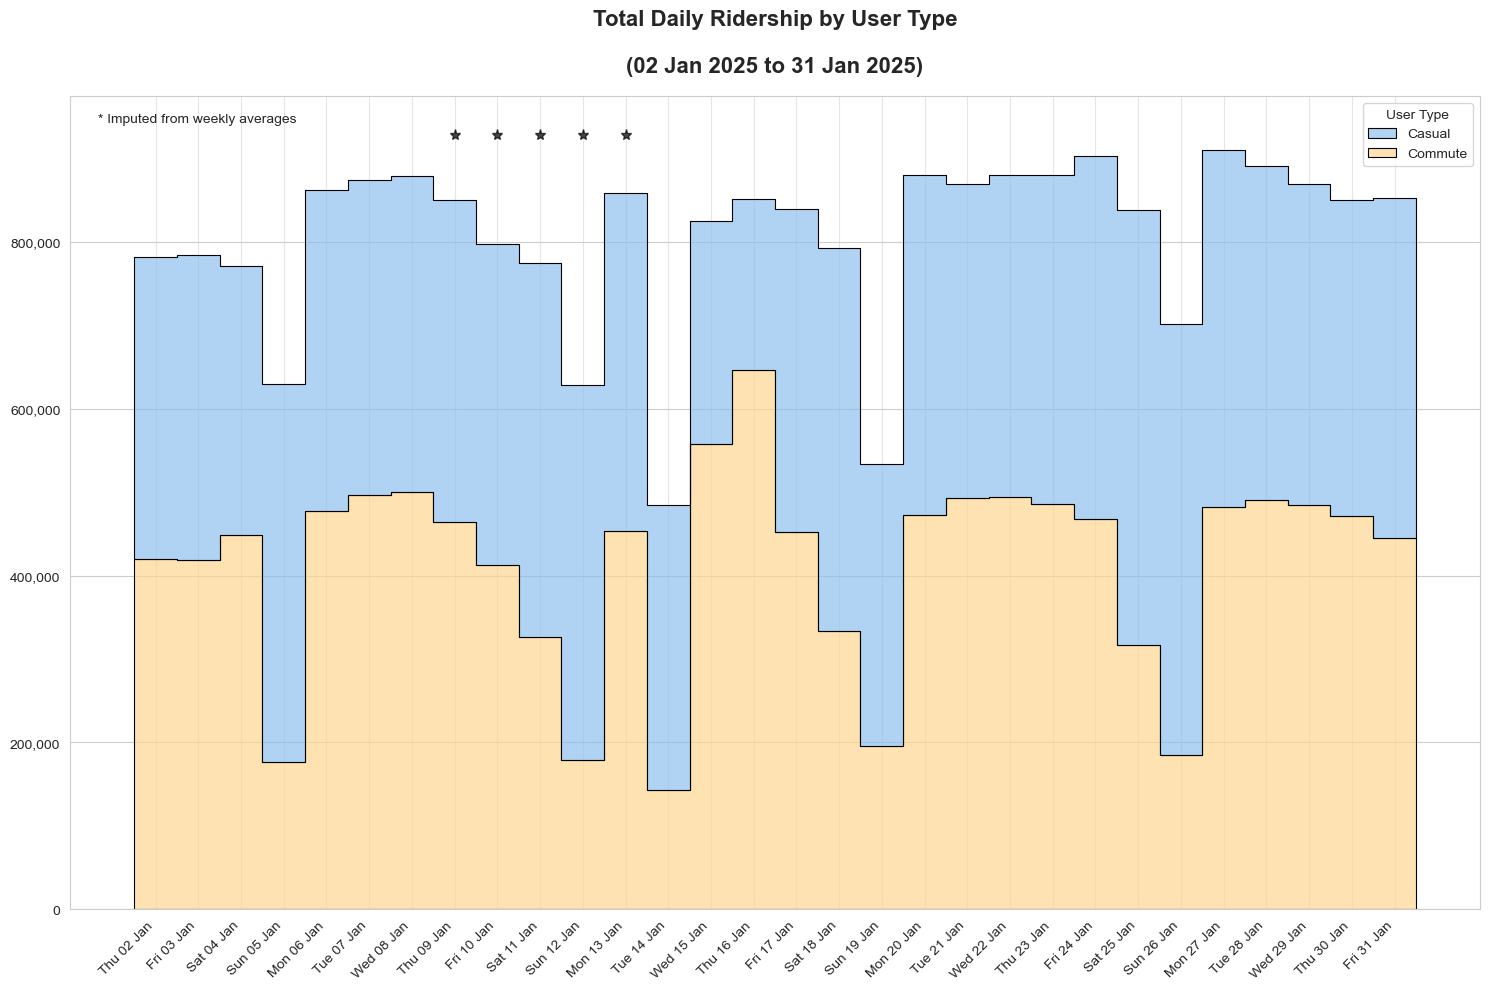

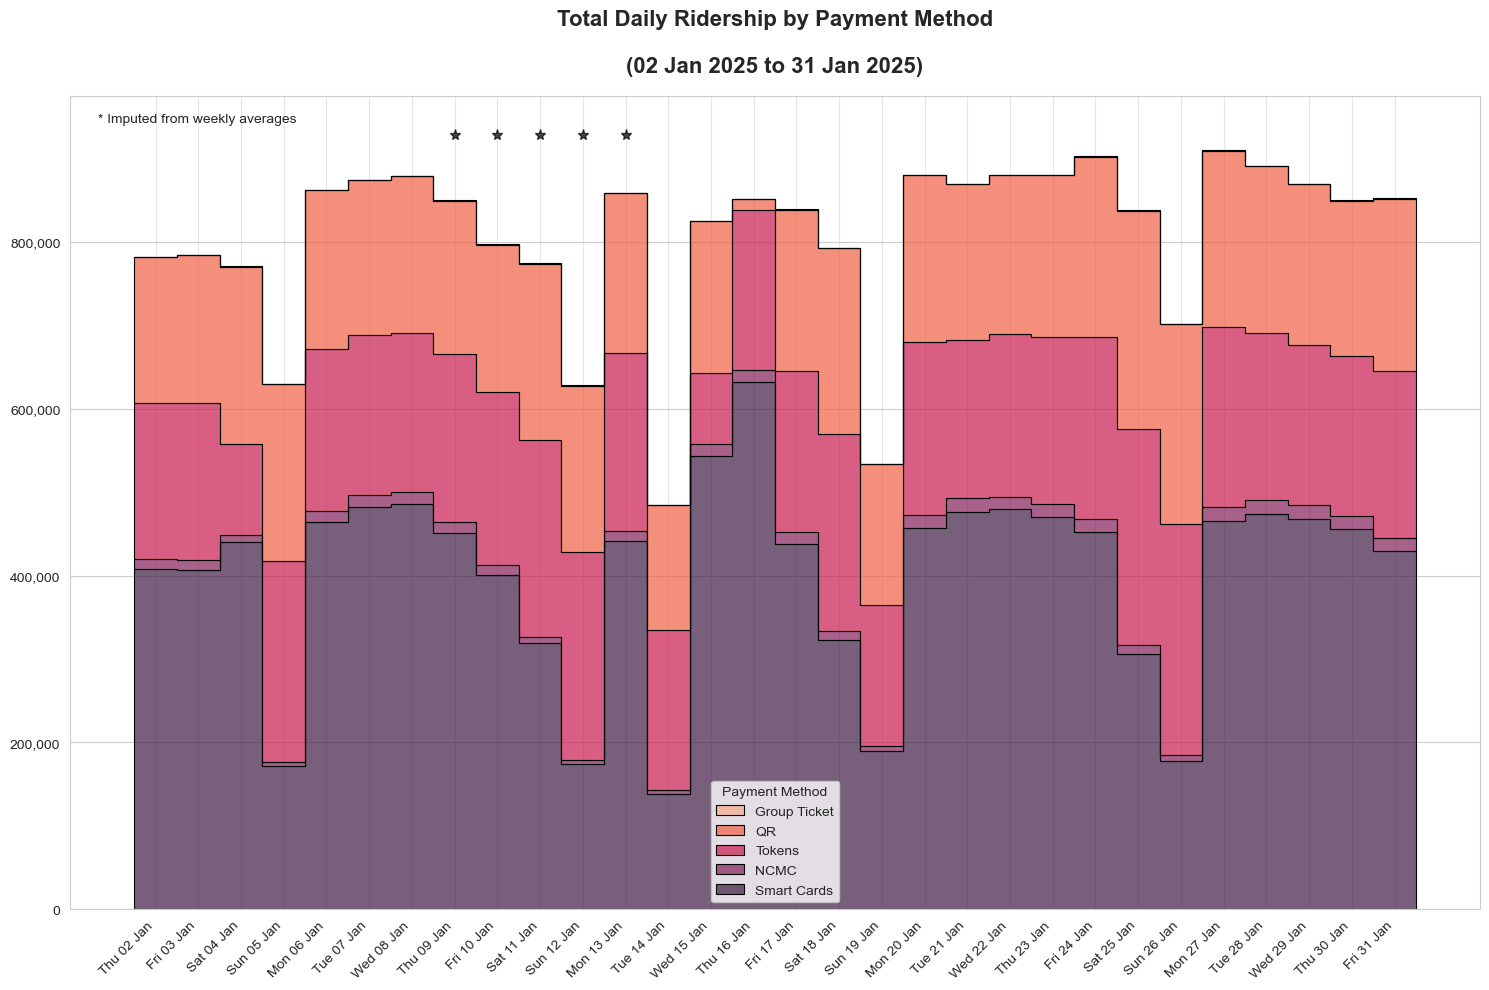

In [38]:
plot_this_df = trimmed_df(df2, number_of_days=31, end_date='2025-01-31', weekly_average=weekly_average)

ax = plot_stacked_ridership(plot_this_df, stack_by='user', traffic_band='all')
ax = plot_stacked_ridership(plot_this_df, stack_by='payment', traffic_band='all')

#### Notes:

1. This stacked histogram provides a comprehensive view of Namma Metro's daily ridership over the past 1 month, broken down by payment methods. 

2. This single plot visualises the **scale of metro operations** (serving hundreds of thousands daily) and the **relative popularity of different payment options** while also highlighting the **strong weekly seasonality in urban transit usage**.

In [106]:
def plot_passes_trend(df, 
                      number_of_days=None, 
                      end_date=None, 
                      pass_types=['One Day Pass', 'Three Day Pass', 'Five Day Pass'],
                      ax=None,
                      significant_dates=False):
    passes_df = df.copy()
    passes_df['Record Date'] = pd.to_datetime(passes_df['Record Date'], dayfirst=True)
    number_of_days = number_of_days if number_of_days else len(passes_df) 
    end_date = pd.to_datetime(end_date) \
        if pd.to_datetime(end_date) <= passes_df['Record Date'].max() \
            else passes_df['Record Date'].max() \
                if end_date else passes_df['Record Date'].max()
    start_date = end_date - pd.Timedelta(days=number_of_days-1)
    passes_df = passes_df[(passes_df['Record Date'] >= start_date) & (passes_df['Record Date'] <= end_date)]
    passes_df['Traffic Band'] = 'Weekday'
    passes_df.loc[(passes_df['Record Date'].dt.dayofweek >= 4), 'Traffic Band'] = 'Weekend Lite'
    passes_df.loc[(passes_df['Record Date'].dt.dayofweek == 6), 'Traffic Band'] = 'Weekend'

    # Define pass types and their corresponding colors
    colors = ['#8b2183', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    traffic_bands = {
        'Monday': ('Weekday', '#e6f0ff'),
        'Tuesday': ('Weekday', '#e6f0ff'),
        'Wednesday': ('Weekday', '#e6f0ff'),
        'Thursday': ('Weekday', '#e6f0ff'),
        'Friday': ('Weekend Lite', '#ffe6e6'),
        'Saturday': ('Weekend Lite', '#ffe6e6'),
        'Sunday': ('Weekend', '#f0e6ff')}

    # Shade traffic bands
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    else:
        fig = ax.figure
    labeled_bands = set()
    current_date = start_date
    while current_date <= end_date:
        day_name = current_date.strftime('%A')
        band, color = traffic_bands[day_name]        
        start_num = mdates.date2num(current_date)
        end_num = mdates.date2num(current_date + pd.Timedelta(days=1))
        if band not in labeled_bands:
            ax.axvspan(start_num, end_num, facecolor=color, alpha=0.7, label=band)
            labeled_bands.add(band)
        else:
            ax.axvspan(start_num, end_num, facecolor=color, alpha=0.7)
        current_date += pd.Timedelta(days=1)

    # Plot each pass type
    for i, pass_type in enumerate(pass_types):
        # Add dummy plots for legend
        ax.plot([], [], color=colors[i], linewidth=2, label=f'{pass_type} (Solid)')
        ax.plot([], [], color=colors[i], linewidth=2, linestyle='--', label=f'{pass_type} (Gaps)')

        # Calculate date differences
        passes_df['date_diff'] = passes_df['Record Date'].diff().dt.days

        # Start a new segment when diff > 1
        passes_df['segment'] = (passes_df['date_diff'] > 1).cumsum()

        # Plot each segment
        for segment in passes_df['segment'].unique():
            segment_data = passes_df[passes_df['segment'] == segment]
            
            # Plot solid line for the segment
            if len(segment_data) > 0:
                ax.plot(segment_data['Record Date'], 
                       segment_data[pass_type],
                       color=colors[i], 
                       linewidth=2)

            # If there's a next segment, plot dashed line between segments
            next_segment = segment + 1
            if next_segment in passes_df['segment'].unique():
                next_segment_data = passes_df[passes_df['segment'] == next_segment]
                if len(next_segment_data) > 0:
                    # Plot dashed line between segments
                    ax.plot([segment_data['Record Date'].iloc[-1], 
                            next_segment_data['Record Date'].iloc[0]],
                           [segment_data[pass_type].iloc[-1], 
                            next_segment_data[pass_type].iloc[0]],
                           color=colors[i], 
                           linewidth=2, 
                           linestyle='--')

    # Add significant dates
    if significant_dates:
        try:
            significant_dates_df = pd.read_csv('significant_dates.csv')
            significant_dates_df['Date'] = pd.to_datetime(significant_dates_df['Date'], format='%Y-%m-%d')
            
            # Get y-axis limits for text positioning
            y_min, y_max = ax.get_ylim()
            text_positions = np.linspace(y_max*0.3, y_max*0.7, len(significant_dates_df))
            
            for idx, (_, row) in enumerate(significant_dates_df.iterrows()):
                date = row['Date']
                event = row['Event']
                if start_date <= date <= end_date:
                    date_num = mdates.date2num(date)
                    ax.axvline(date_num, color='#FF6B6B', linestyle='--', linewidth=1, alpha=0.7)
                    
                    # Position text at different heights to avoid overlap
                    ax.text(date_num, text_positions[idx], event, 
                           rotation=90, 
                           verticalalignment='bottom',
                           horizontalalignment='right',
                           color='#FF6B6B',
                           fontsize=12,
                           fontweight='bold',
                           alpha=0.8,
                           bbox=dict(facecolor='white', 
                                   edgecolor='none',
                                   alpha=0.7,
                                   pad=2))
        except FileNotFoundError:
            print("significant_dates.csv not found. Skipping significant dates annotation.")

    # Format the plot
    metrics_text = 'Multiple Metrics' if len(pass_types) > 2 else ' vs '.join(pass_types)
    title = f"{metrics_text} Usage Trend\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})"
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    x_min = passes_df['Record Date'].min() - pd.Timedelta(days=0.5)
    x_max = passes_df['Record Date'].max() + pd.Timedelta(days=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(passes_df['Record Date'])
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('', fontsize=12)
    plt.ylabel('', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Remove duplicate band labels
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), fontsize=10)
    plt.tight_layout()
    if ax is None:
        plt.show()
        return fig, ax
    else:
        return None, None

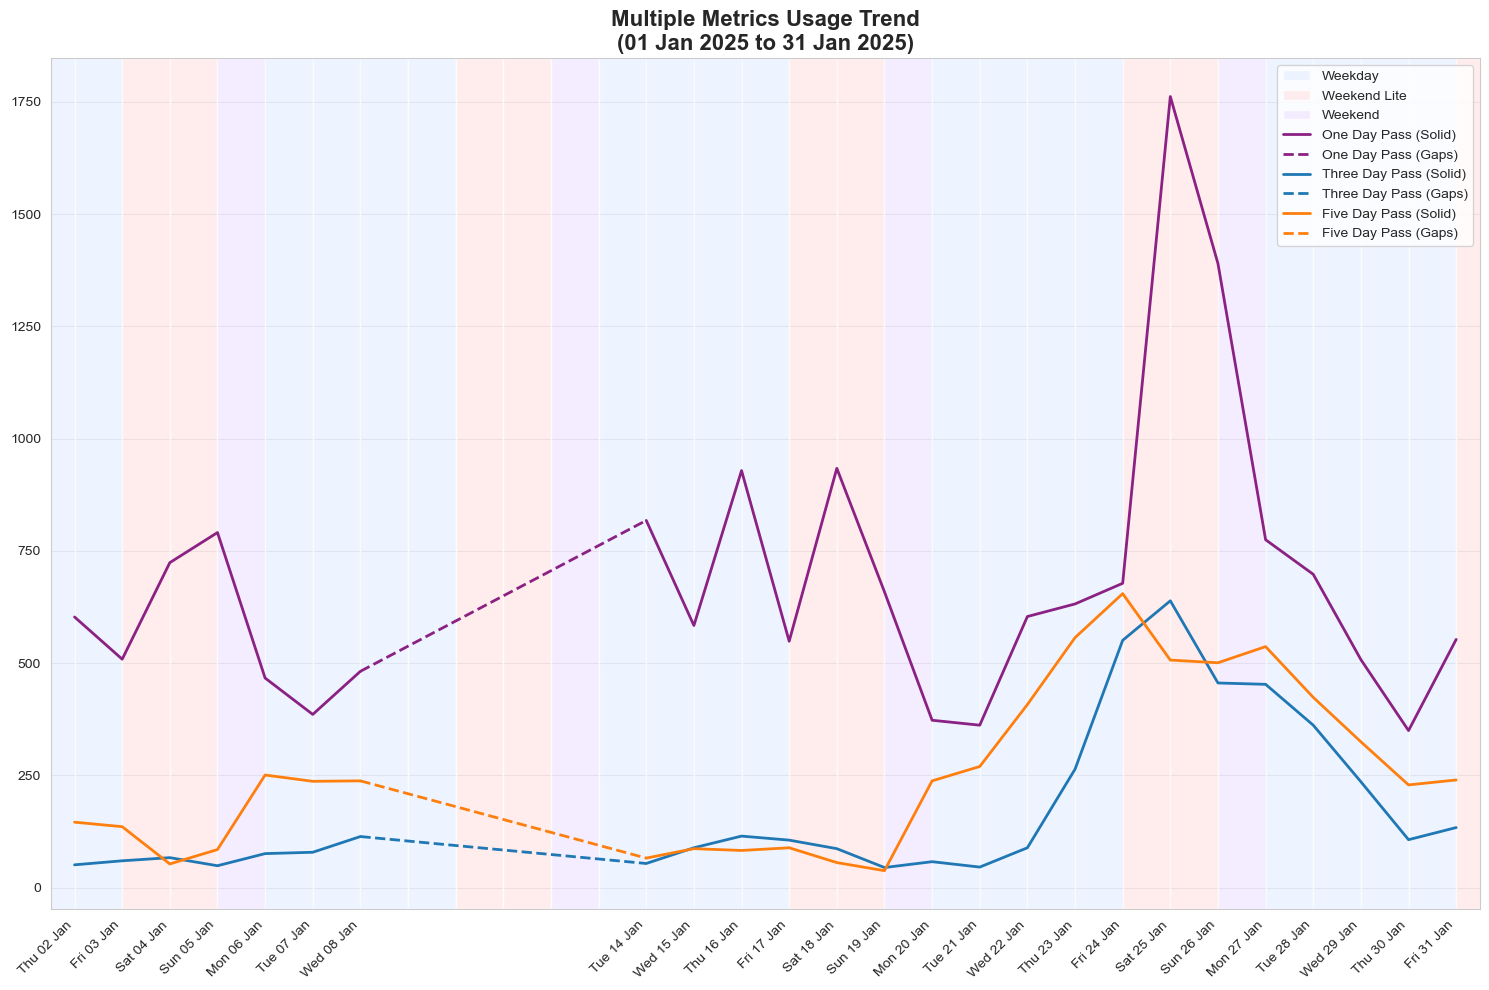

In [107]:
end_date = '2025-01-31'
number_of_days = 31
pass_types = ['One Day Pass', 'Three Day Pass', 'Five Day Pass']
# pass_types = ['QR Paytm', 'QR WhatsApp', 'QR NammaMetro']

ax = plot_passes_trend(df, 
                    number_of_days=number_of_days, 
                    end_date=end_date, 
                    pass_types=pass_types)

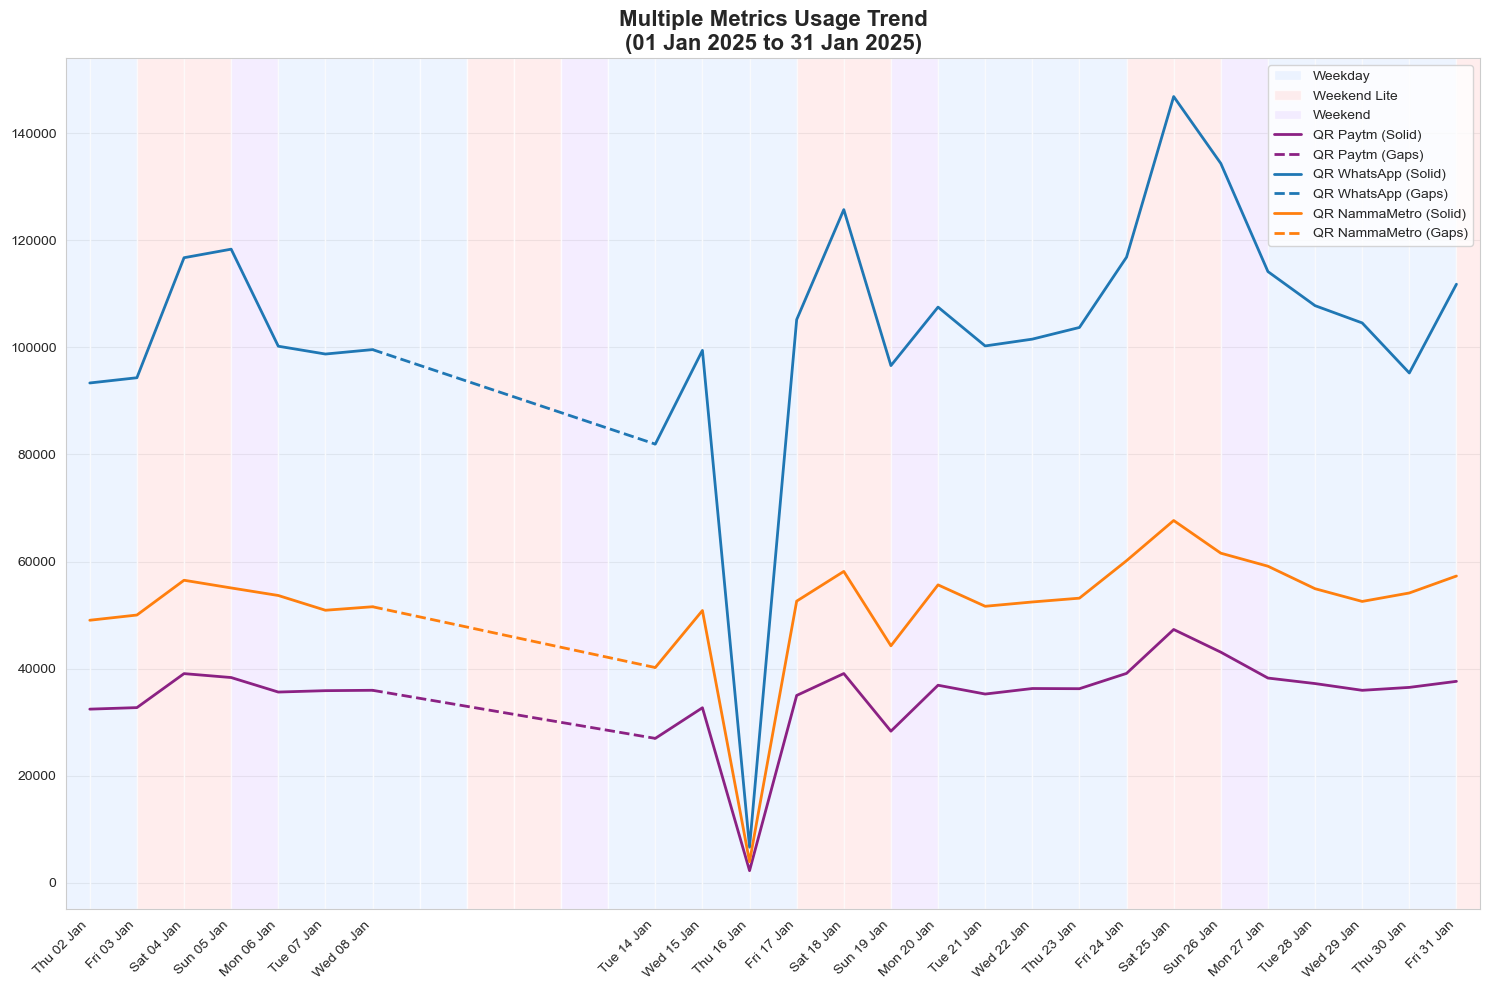

In [108]:
end_date = '2025-01-31'
number_of_days = 31
pass_types = ['QR Paytm', 'QR WhatsApp', 'QR NammaMetro']

ax = plot_passes_trend(df, 
                    number_of_days=number_of_days, 
                    end_date=end_date, 
                    pass_types=pass_types)

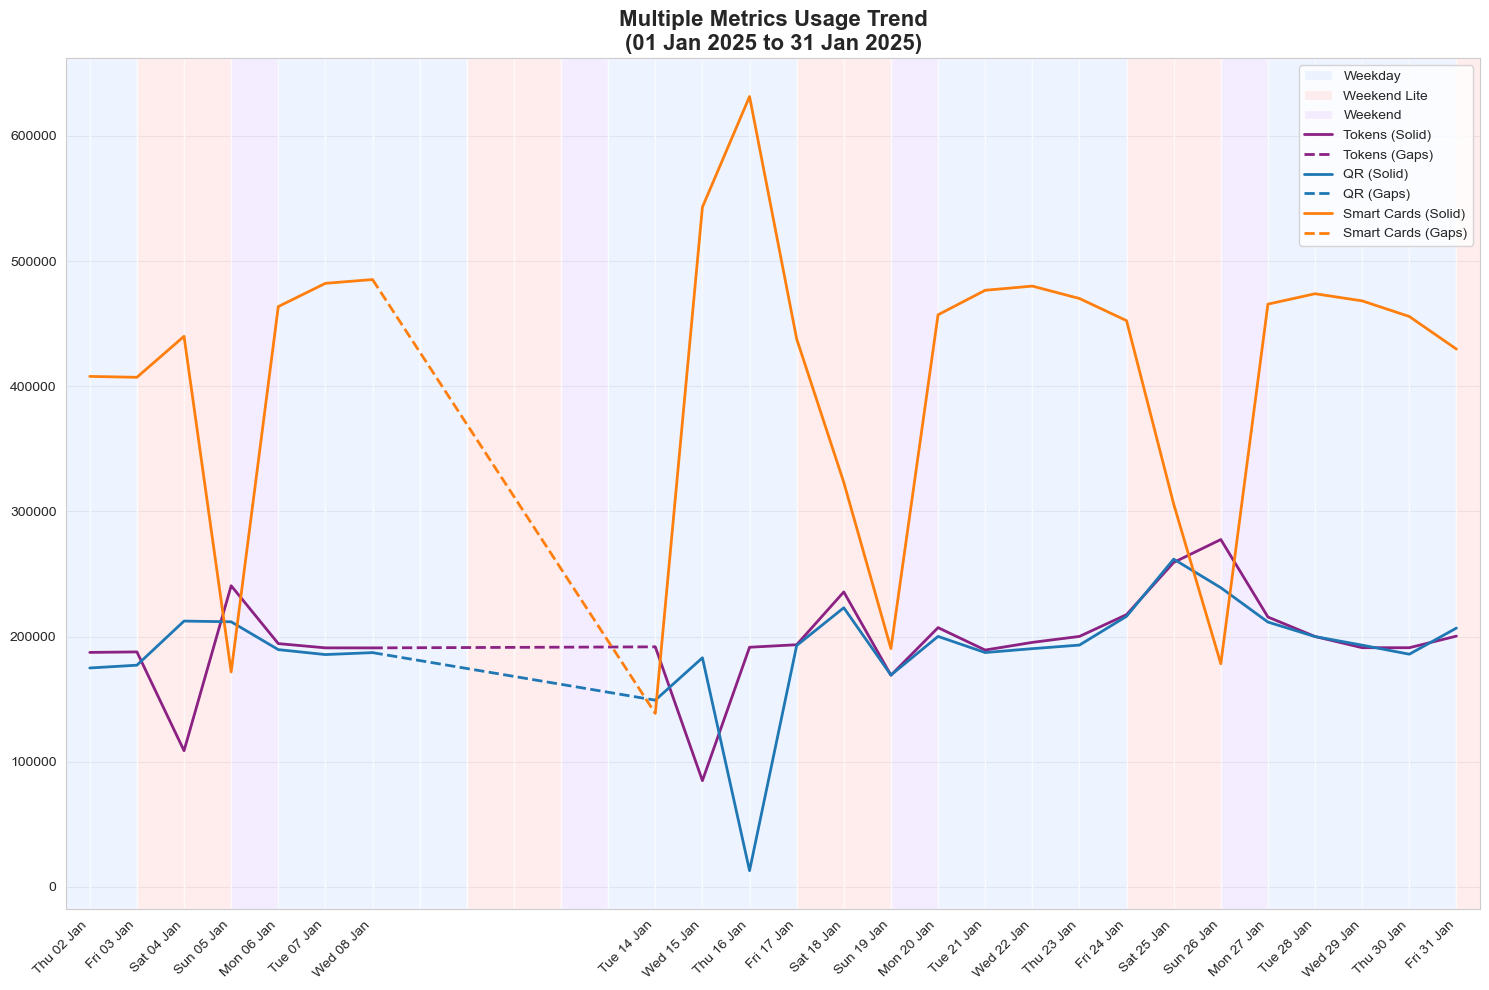

In [110]:
end_date = '2025-01-31'
number_of_days = 31
pass_types = ['Tokens', 'QR', 'Smart Cards']

ax = plot_passes_trend(df2, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=False)

_____
## Fare Hike Impact Analysis

> 💡 **Did commuters abandon NammaMetro in the week following the fare hike?**
> 
> NammaMetro's Fare Fixation Committee recommended an upward revision of fares after seven-and-a-half years [starting from February 9, 2025](https://www.thehindu.com/news/cities/bangalore/after-bus-fare-hike-bengalureans-will-now-have-to-shell-out-more-for-namma-metro-rides-from-feb-9/article69196596.ece). 
>
>The decision proved hugely unpopular with regular metro users as well as public transport activists, more so when they realised the actual fare hike at the turnstiles was far greater than what they had been led to believe. 
>
>The media caught onto the public sentiment and widely reported a [drastic drop in ridership](https://www.deccanherald.com/india/karnataka/bengaluru/metro-ridership-falls-by-10-bmrcl-rules-out-rationalisation-of-fare-slabs-3403164) with every passing day following the fare hike.
> 
>
> So, did commuters abandon NammaMetro in droves in a manner of protest against the fare hike? We will use statistical data analysis to arrive at an answer.

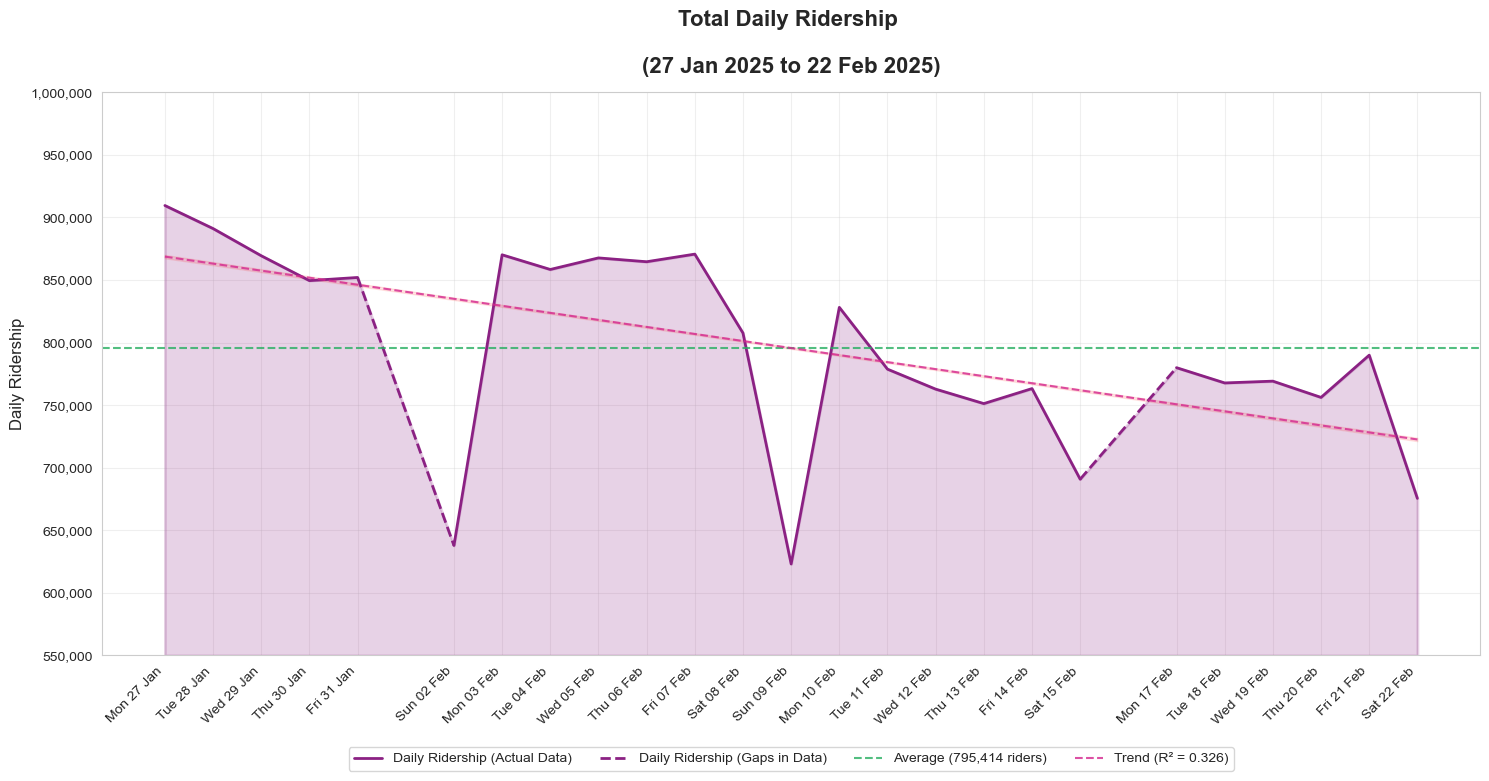

In [43]:
# Get data for 2 weeks before and after Feb 9 fare hike
before_hike = trimmed_df(df2, 
                        end_date='2025-02-08',
                        number_of_days=14)

after_hike = trimmed_df(df2, 
                       end_date='2025-02-23',
                       number_of_days=14)

# Plot overall trend including the transition period
transition_period = trimmed_df(df2, 
                             end_date='2025-02-23',
                             number_of_days=28)  # ~2.5 weeks before and after

# Look at overall impact
ax = plot_ridership_trend(transition_period, base_value=550000)

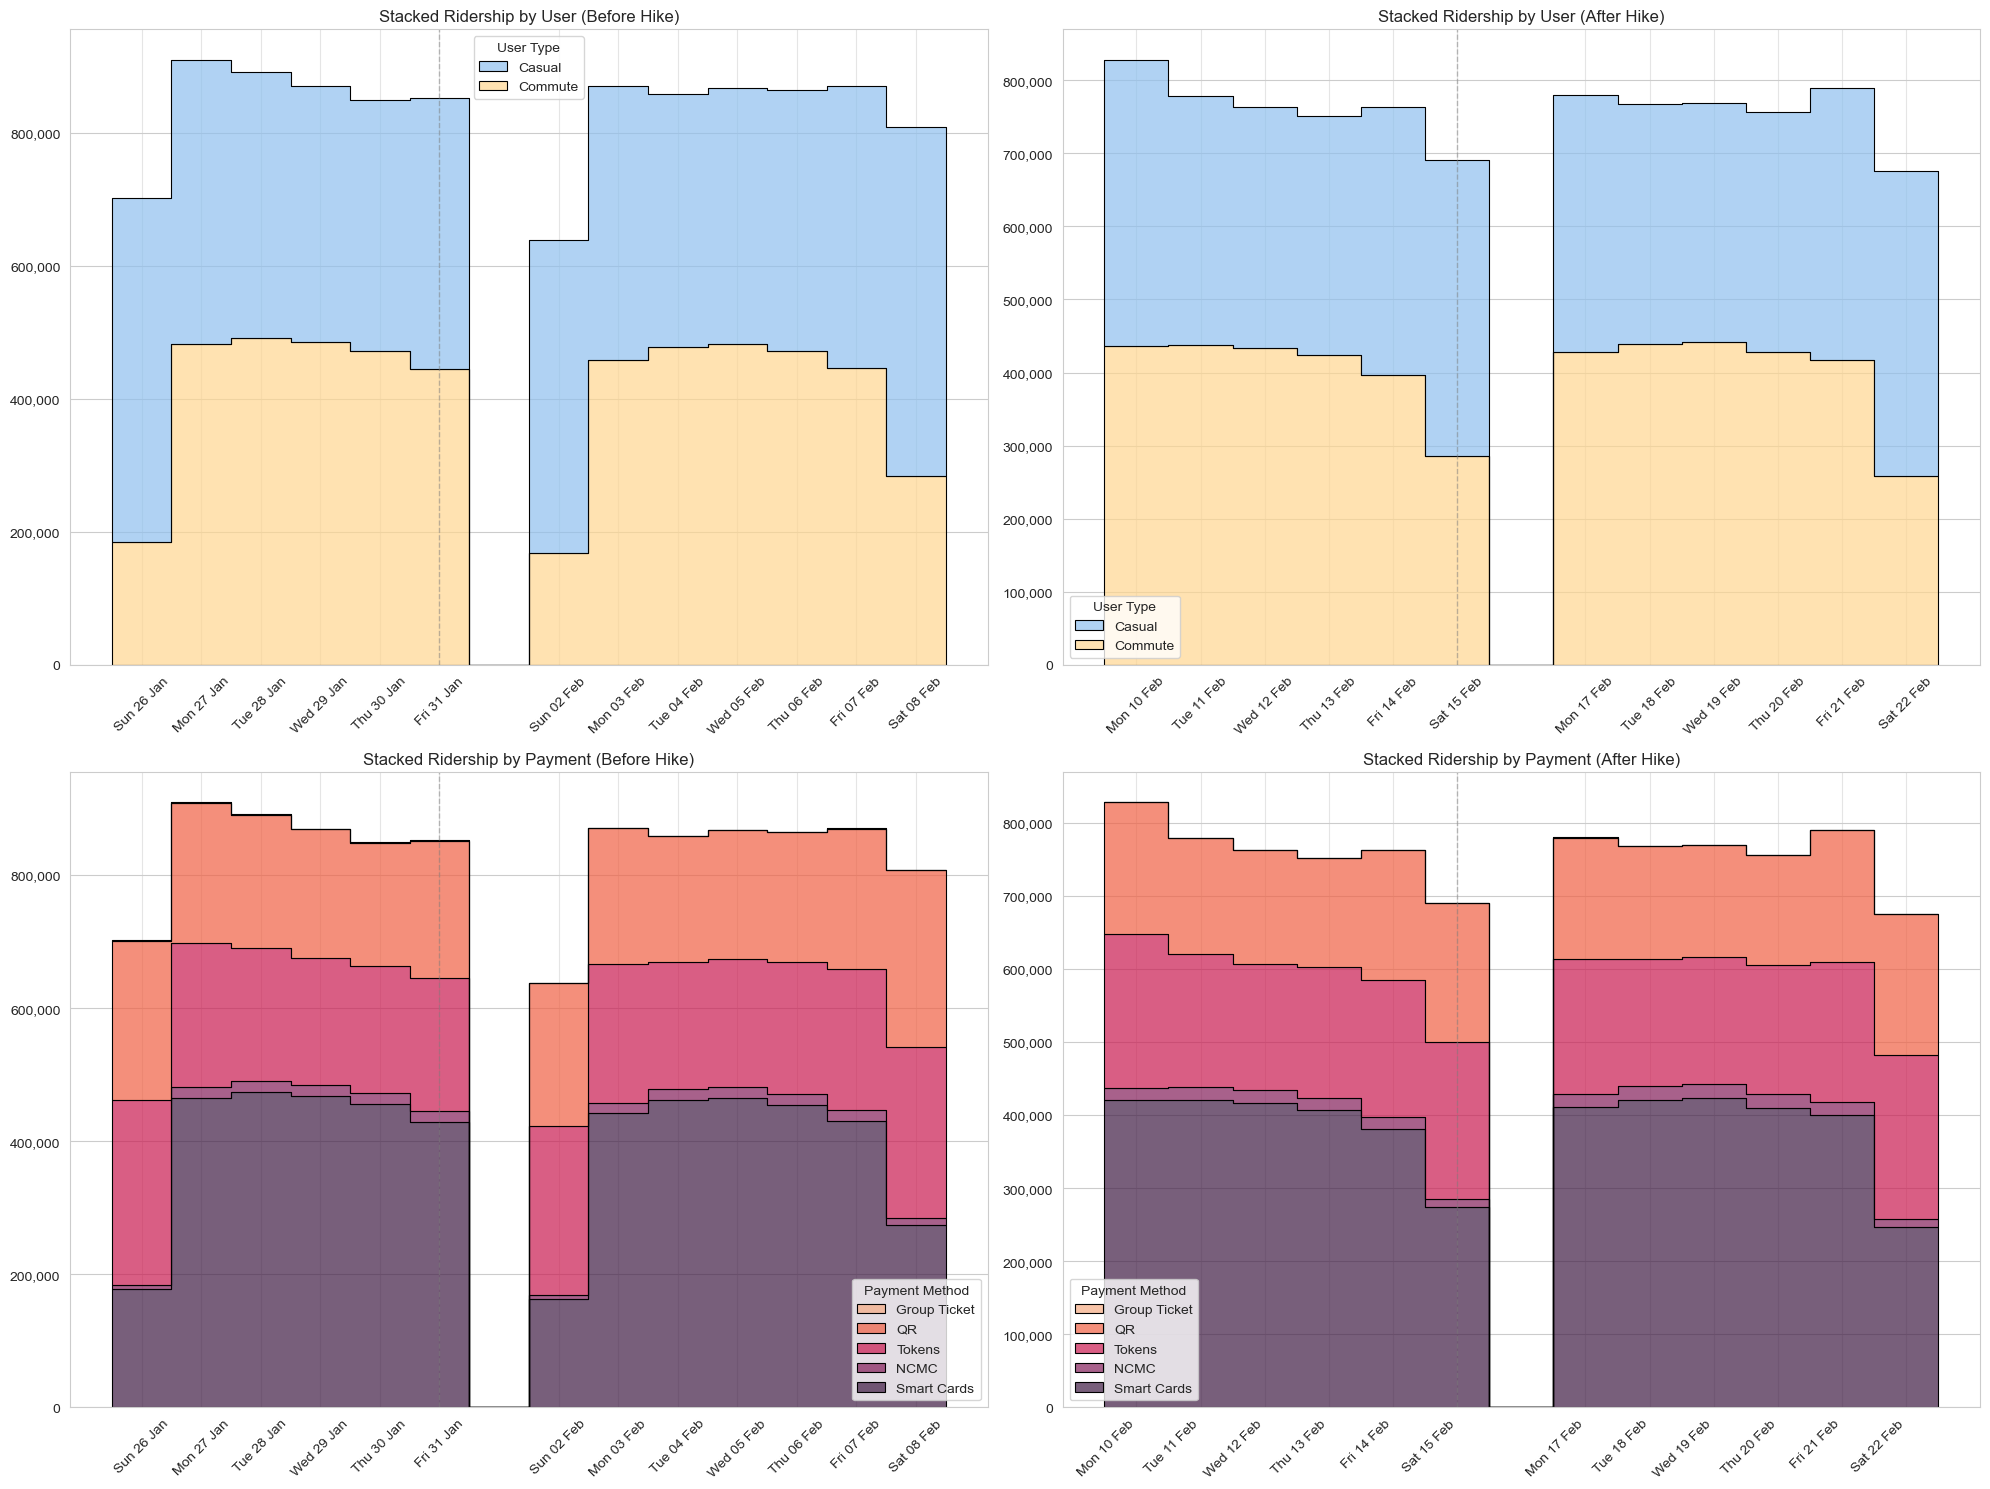

In [44]:
datasets = [before_hike, after_hike, before_hike, after_hike]
stack_by_options = ['user', 'user', 'payment', 'payment']

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
for i, (dataset, stack_by) in enumerate(zip(datasets, stack_by_options)):
    ax = axes[i]
    plot_stacked_ridership(dataset, stack_by=stack_by, traffic_band='all', ax=ax)
    ax.set_title(f'Stacked Ridership by {stack_by.capitalize()} ({["Before", "After"][i%2]} Hike)')

plt.tight_layout()
plt.show()

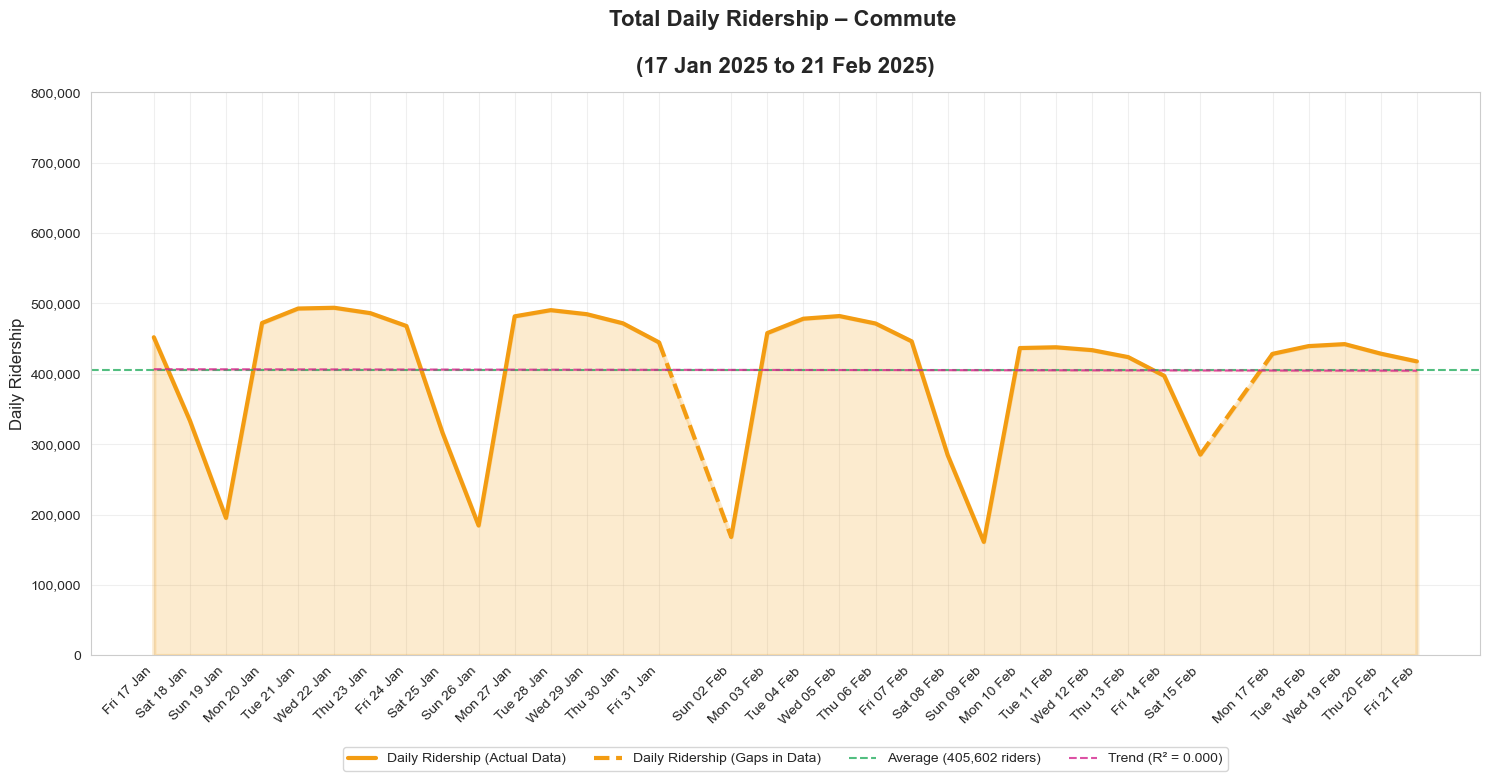

In [ ]:
plot_this_df = trimmed_df(df2, 
                          number_of_days=7*6, 
                          end_date='2025-02-21', 
                          exclude_dates=['2025-01-14','2025-01-15','2025-01-16'])
# plot_this_df = trimmed_df(plot_this_df, exclude_dates=['2025-01-14','2025-01-15','2025-01-16'])
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Commute', base_value=00000)

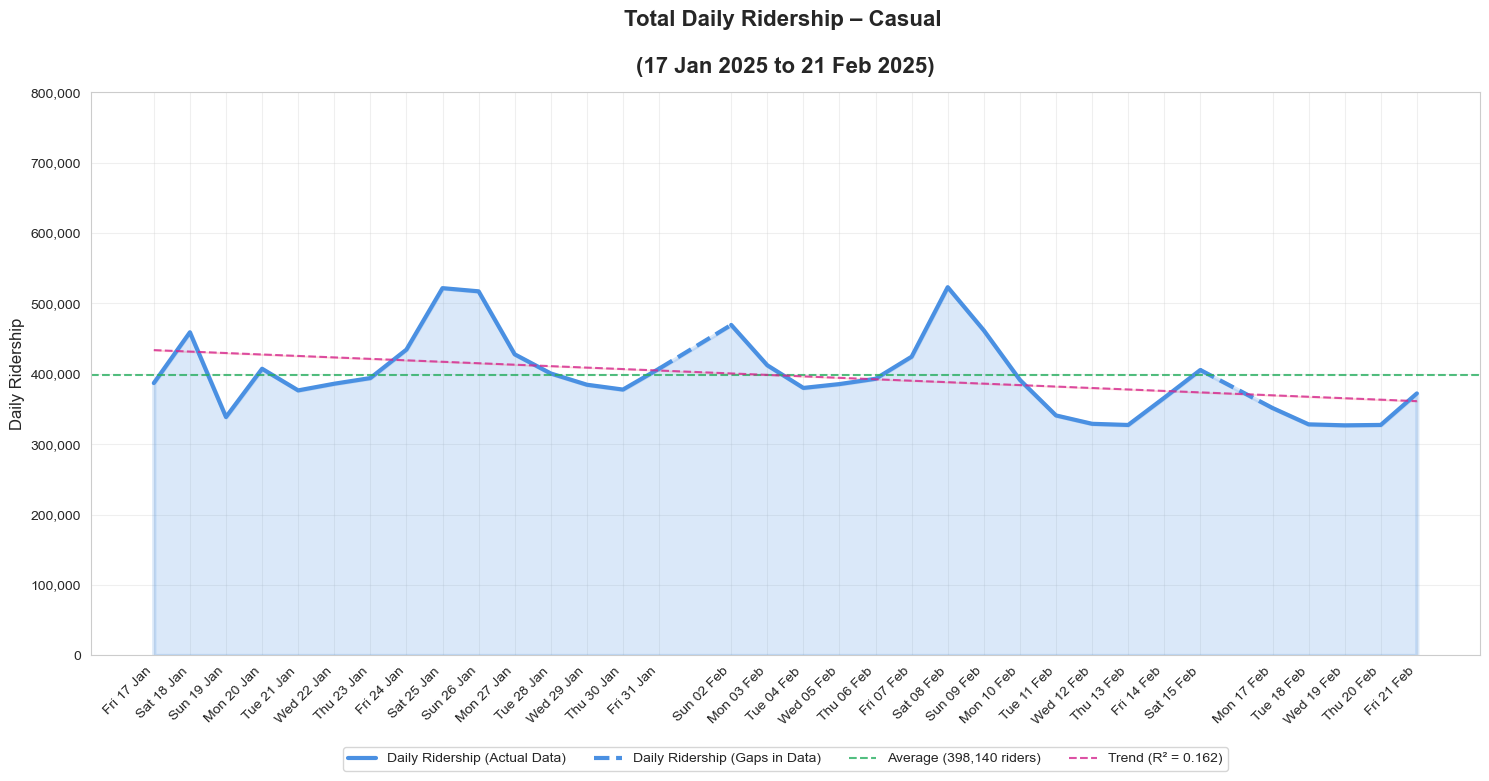

In [46]:
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Casual', base_value=00000)

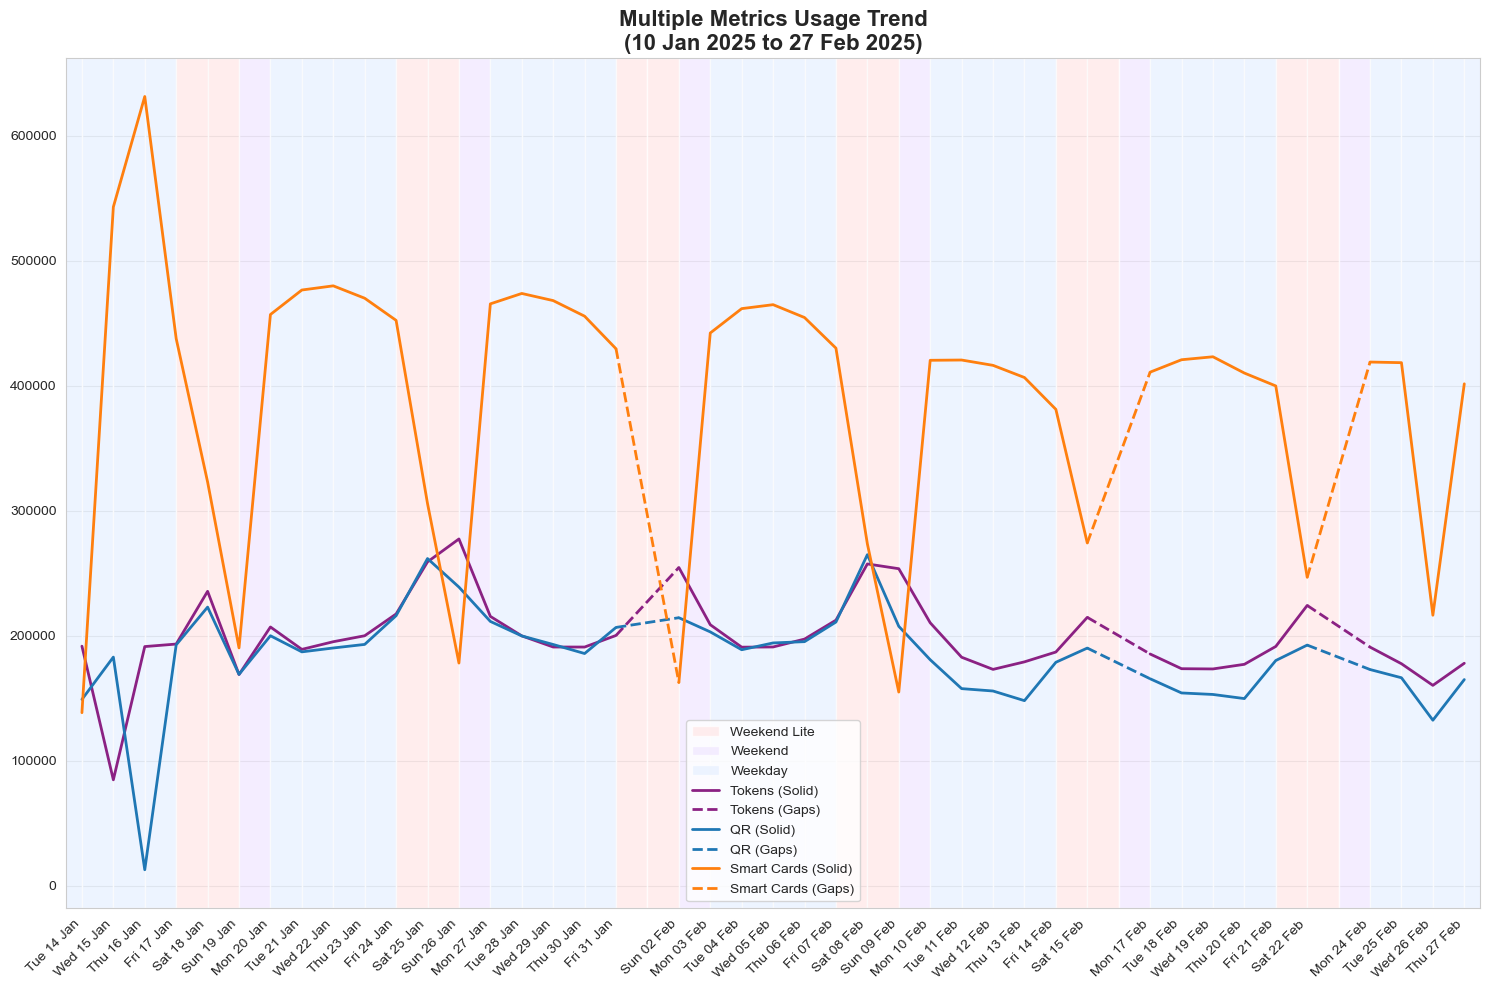

In [105]:
end_date = '2025-02-28'
number_of_days = 7*7
pass_types = ['Tokens', 'QR', 'Smart Cards']

ax = plot_passes_trend(df2, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=False)

In [ ]:
# Sort the CSV file while preserving the header
# (head -n 1 significant_dates.csv && tail -n +2 significant_dates.csv | sort -t, -k1) > temp.csv && mv temp.csv significant_dates.csv

### Post-Hike Test of Statistical Significance

In [ ]:
def ttest(df_stats, variable, observed_value, alpha=0.05):
    """Perform t-test for a single observation against historical data."""
    sample_mean = df_stats.loc['mean', variable]  # Fixed indexing
    sample_std = df_stats.loc['std', variable]    # Fixed indexing
    degrees_of_freedom = df_stats.loc['count', variable] - 1

    t_stat = (observed_value - sample_mean) / (sample_std / np.sqrt(1))
    p_value = min(t.cdf(t_stat, degrees_of_freedom), t.sf(t_stat, degrees_of_freedom))

    return t_stat, p_value

def significance_test(df, weekly_average, test_date, variables=None, alpha=0.05):
    """
    Compare metrics against weekly averages and return results in markdown format.
    
    Parameters:
    -----------
    df2: DataFrame with daily ridership data
    weekly_average: DataFrame with pre-calculated weekly averages by day
    test_date: str or datetime, date to test
    variables: list of metrics to analyze
    alpha: significance level (default: 0.05)
    """
    if variables is None:
        variables = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket']
    
    # Convert test date to pandas datetime
    test_date = pd.to_datetime(test_date)
    day_of_week = test_date.strftime('%A')
    
    # Generate markdown header
    confidence = int((1 - alpha) * 100)
    md_output = [
        f"  ",
        f"**Test Date**: {test_date.strftime('%d %b %Y')}   ",
        f"**Baseline**: Historical {day_of_week} averages   ",
        f"**Confidence Level**: {confidence}%",
        "",
        "| Metric | Observed | Weekly Mean | Change % | t-statistic | p-value | Significant |",
        "|--------|----------|-------------|----------|-------------|----------|-------------|"
    ]
    
    # Get test date data
    test_data = df[df['Record Date'] == test_date]
    if test_data.empty:
        md_output.append(f"\n> No data found for test date: {test_date}")
        return '\n'.join(md_output)
    
    # Get same-day data for standard deviation calculation
    same_day_data = df[pd.to_datetime(df['Record Date']).dt.day_name() == day_of_week]
    
    for var in variables:
        observed_value = test_data[var].iloc[0]
        weekly_mean = weekly_average.loc[day_of_week, var]
        weekly_std = same_day_data[var].std()
        weekly_count = len(same_day_data)
        
        t_stat = (observed_value - weekly_mean) / (weekly_std / np.sqrt(1))
        p_value = min(t.cdf(t_stat, weekly_count - 1), t.sf(t_stat, weekly_count - 1))
        
        # Add row to markdown table
        significant = ('⬆︎' if t_stat > 0 else '⬇︎') if (p_value < alpha) else '🚫'
        md_output.append(
            f"| {var} | {int(observed_value):,d} | {int(weekly_mean):,d} | "
            f"{round(((observed_value / weekly_mean) - 1) * 100, 1):+.1f}% | "
            f"{t_stat:+.2f} | {p_value:.4f} | {significant} |"
        )
    
    return '\n'.join(md_output)

def analyze_payment_migration(df, weekly_average, test_date, variables=None, days_to_analyze=5):
    """
    Analyze how metrics deviate from historical patterns.
    
    Parameters:
    -----------
    df2: DataFrame with daily ridership data
    weekly_average: DataFrame with pre-calculated weekly averages by day
    test_date: str or datetime, start date of analysis period
    variables: list of metrics to analyze (default: payment methods)
    days_to_analyze: int, number of days to analyze
    """
    if variables is None:
        variables = ['Smart Cards', 'NCMC', 'Tokens', 'QR']
    
    # Get test period data
    dates = pd.date_range(start=test_date, periods=days_to_analyze, freq='D')
    test_data = df[df['Record Date'].isin(dates)].copy()
    
    if test_data.empty:
        return None, None
    
    # Add day of week and historical averages
    test_data['Day of Week'] = pd.to_datetime(test_data['Record Date']).dt.day_name()
    analysis_data = pd.DataFrame()
    
    # Calculate deviations from historical averages
    for metric in variables:
        actual = test_data.set_index('Day of Week')[metric]
        expected = weekly_average[metric]
        deviation = ((actual / expected) - 1) * 100
        analysis_data[f'{metric}_deviation'] = deviation
    
    # Compute correlation matrix of deviations
    corr_matrix = analysis_data.corr()
    
    return analysis_data, corr_matrix

def plot_payment_correlation_heatmap(corr_matrix, title=None):
    """Plot correlation heatmap of payment method deviations."""
    if corr_matrix is None:
        return None
    
    # Clean up column names for display
    display_names = {col: col.replace('_deviation', '') 
                    for col in corr_matrix.columns}
    corr_matrix = corr_matrix.rename(columns=display_names)
    corr_matrix = corr_matrix.rename(index=display_names)
    
    mask = np.eye(len(corr_matrix), dtype=bool)
    fig, ax = plt.subplots(figsize=(8, 6))    

    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='RdYlBu_r',
                vmin=-1, vmax=1,
                center=0,
                square=True,
                cbar_kws={'label': ''},
                ax=ax)
    
    if title is None:
        title = (f"Payment Method Migration Analysis\n"
                f"Correlation of Deviations from Historical Averages")
    
    plt.title(title, fontsize=12, y=1.02, fontweight='bold')
    plt.figtext(0.05, -0.15, 
        "How to read this chart:\n" +
        "• Red: payment methods deviating together from their averages\n" +
        "• Blue: payment methods deviating in opposite directions\n" +
        "• Darker colors: stronger relationships\n" +
        "• Values range from -1 (perfect negative) to +1 (perfect positive)",
        fontsize=10, 
        bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

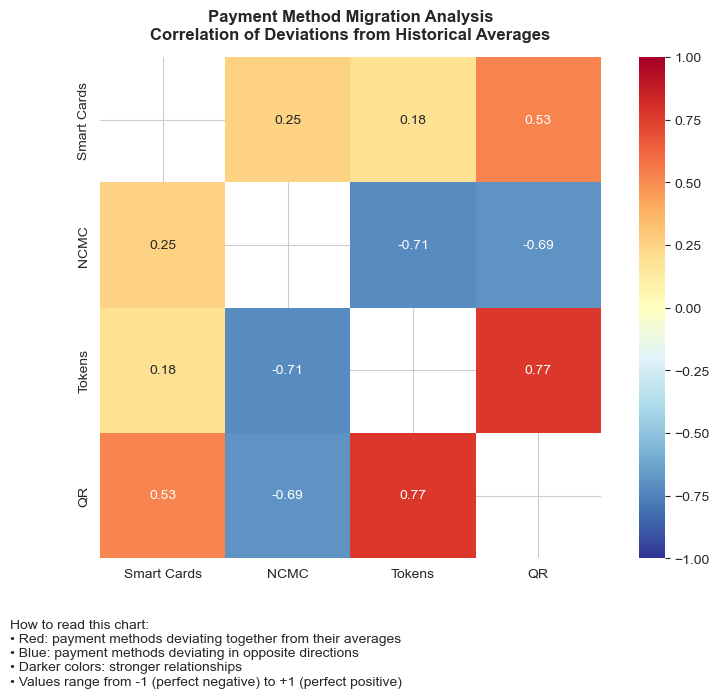

In [52]:
# Define variables to test (payment methods)
test_date = '2025-02-10'
variables = ['Commute', 'Casual', 'Total']
variables = ['Smart Cards', 'NCMC', 'Tokens', 'QR']

analysis_data, corr_matrix = analyze_payment_migration(df2, weekly_average, test_date, variables, days_to_analyze=4)
fig = plot_payment_correlation_heatmap(corr_matrix)

In [74]:
test_dates = ['2025-02-10', '2025-02-14']
test_dates = ['2025-02-17', '2025-02-21']
variables = ['Smart Cards', 'NCMC', 'Commute', 'Tokens', 'QR', 'Casual', 'Total']

start_date = test_dates[0]
if len(test_dates) == 1:
    end_date = start_date
else:
    end_date = test_dates[1]
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_range = date_range.strftime('%Y-%m-%d').tolist()

display(Markdown("### Significance Test Results"))
for test_date in date_range:
    display(Markdown(significance_test(df2, weekly_average, test_date, variables, alpha=0.05)))

### Significance Test Results

   

**Test Date**: 17 Feb 2025   
**Baseline**: Historical Monday averages   
**Confidence Level**: 95%

| Metric | Observed | Weekly Mean | Change % | t-statistic | p-value | Significant |
|--------|----------|-------------|----------|-------------|----------|-------------|
| Smart Cards | 410,935 | 441,462 | -6.9% | -0.97 | 0.1740 | 🚫 |
| NCMC | 17,494 | 12,493 | +40.0% | +1.72 | 0.0537 | 🚫 |
| Commute | 428,429 | 453,955 | -5.6% | -0.80 | 0.2197 | 🚫 |
| Tokens | 185,485 | 212,673 | -12.8% | -1.97 | 0.0344 | ⬇︎ |
| QR | 165,679 | 191,298 | -13.4% | -2.14 | 0.0253 | ⬇︎ |
| Casual | 351,533 | 404,532 | -13.1% | -2.37 | 0.0163 | ⬇︎ |
| Total | 779,962 | 858,487 | -9.1% | -1.86 | 0.0422 | ⬇︎ |

   

**Test Date**: 18 Feb 2025   
**Baseline**: Historical Tuesday averages   
**Confidence Level**: 95%

| Metric | Observed | Weekly Mean | Change % | t-statistic | p-value | Significant |
|--------|----------|-------------|----------|-------------|----------|-------------|
| Smart Cards | 420,869 | 451,571 | -6.8% | -0.35 | 0.3660 | 🚫 |
| NCMC | 18,587 | 13,078 | +42.1% | +1.56 | 0.0685 | 🚫 |
| Commute | 439,456 | 464,649 | -5.4% | -0.28 | 0.3917 | 🚫 |
| Tokens | 173,720 | 212,094 | -18.1% | -1.00 | 0.1650 | 🚫 |
| QR | 154,323 | 177,701 | -13.2% | -1.08 | 0.1483 | 🚫 |
| Casual | 328,298 | 390,332 | -15.9% | -1.92 | 0.0359 | ⬇︎ |
| Total | 767,754 | 854,981 | -10.2% | -0.92 | 0.1855 | 🚫 |

   

**Test Date**: 19 Feb 2025   
**Baseline**: Historical Wednesday averages   
**Confidence Level**: 95%

| Metric | Observed | Weekly Mean | Change % | t-statistic | p-value | Significant |
|--------|----------|-------------|----------|-------------|----------|-------------|
| Smart Cards | 423,244 | 438,200 | -3.4% | -0.16 | 0.4379 | 🚫 |
| NCMC | 19,035 | 12,355 | +54.1% | +1.97 | 0.0344 | ⬆︎ |
| Commute | 442,279 | 450,555 | -1.8% | -0.09 | 0.4662 | 🚫 |
| Tokens | 173,529 | 209,385 | -17.1% | -0.85 | 0.2052 | 🚫 |
| QR | 153,112 | 192,182 | -20.3% | -1.43 | 0.0870 | 🚫 |
| Casual | 326,905 | 402,212 | -18.7% | -1.18 | 0.1279 | 🚫 |
| Total | 769,184 | 852,767 | -9.8% | -0.88 | 0.1962 | 🚫 |

   

**Test Date**: 20 Feb 2025   
**Baseline**: Historical Thursday averages   
**Confidence Level**: 95%

| Metric | Observed | Weekly Mean | Change % | t-statistic | p-value | Significant |
|--------|----------|-------------|----------|-------------|----------|-------------|
| Smart Cards | 410,223 | 450,936 | -9.0% | -0.66 | 0.2601 | 🚫 |
| NCMC | 18,498 | 12,935 | +43.0% | +2.11 | 0.0269 | ⬆︎ |
| Commute | 428,721 | 463,871 | -7.6% | -0.57 | 0.2891 | 🚫 |
| Tokens | 177,235 | 201,499 | -12.0% | -2.11 | 0.0266 | ⬇︎ |
| QR | 149,822 | 183,966 | -18.6% | -0.75 | 0.2320 | 🚫 |
| Casual | 327,479 | 386,036 | -15.2% | -1.16 | 0.1327 | 🚫 |
| Total | 756,200 | 849,907 | -11.0% | -1.67 | 0.0587 | 🚫 |

   

**Test Date**: 21 Feb 2025   
**Baseline**: Historical Friday averages   
**Confidence Level**: 95%

| Metric | Observed | Weekly Mean | Change % | t-statistic | p-value | Significant |
|--------|----------|-------------|----------|-------------|----------|-------------|
| Smart Cards | 399,905 | 400,858 | -0.2% | -0.01 | 0.4959 | 🚫 |
| NCMC | 17,821 | 11,518 | +54.7% | +1.70 | 0.0561 | 🚫 |
| Commute | 417,726 | 412,376 | +1.3% | +0.06 | 0.4775 | 🚫 |
| Tokens | 191,533 | 206,976 | -7.5% | -1.15 | 0.1342 | 🚫 |
| QR | 180,270 | 176,938 | +1.9% | +0.10 | 0.4601 | 🚫 |
| Casual | 372,226 | 384,528 | -3.2% | -0.33 | 0.3734 | 🚫 |
| Total | 789,952 | 796,904 | -0.9% | -0.06 | 0.4781 | 🚫 |